# Apply Gaussian Mixture Modeling (GMM) to UKESM1 ozone dataset

This example notebook contains code used to apply GMM to the UKESM1 ozone dataset.

## Initial setup

#### Import modules

We used scikit-learn (sklearn), matplotlib, pandas cartopy, and numpy

In [1]:
!pip install texttable latextable

In [2]:
#import scikit-learn
from sklearn import mixture
from sklearn import preprocessing
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

# import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib as mpl

# import pandas, numpy, etc.
import pandas as pd
import numpy as np
import os.path
import random
import pickle
import xarray as xr
import json

# for label map
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import mpl_toolkits

# for automatic table formatting
from texttable import Texttable
import latextable



#### Set parameters

Here we select number of classes based on BIC score and manually. There are many other ways than BIC to justify choices when it comes to the number of classes.

In [3]:
# number of components (before manual grouping)
n_components_selected = 6

#saving figures
save_figs = False

# manual grouping
manual_grouping = False

# manual grouping vector
manual_classes = [0, 0, 1, 2, 3, 4, 5, 5]

# check to make sure that n_comp is as expected (uncomment this to check n_comp)
#n_comp = best_gmm.n_components

# set n_comp to manually selected value based on our further grouping
if manual_grouping==True:
    n_comp_manual = 6
    n_comp = n_comp_manual
else:
    n_comp = n_components_selected

#### Import data

Here we combine ozone profiles experiments into a single training dataset from:

     1) Historical: Annual means covering the years 2004-2014
     2) SSP1-2.6: Annual means covering the years 2090-2100 (strong emission reductions)
     3) SSP5-8.5: Annual means covering the years 2090-2100 (no emission reductions)
     
GMM will be trained on this combined dataset, such that it is exposed to the full variety of ozone states in the dataset. This will make the model more general than if it had only been trained on a single scenario. 

In [4]:
#import data
data1 = pd.read_csv('data_in/historical_seasonal.csv')
data2 = pd.read_csv('data_in/ssp126_seasonal.csv')
data3 = pd.read_csv('data_in/ssp585_seasonal.csv')
data = data1.append([data1,data2,data3], ignore_index=True) #append data
data #data load

/tmp/ipykernel_2506/358274946.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data1.append([data1,data2,data3], ignore_index=True) #append data


x       y season      1000       925       850       700  \
0         0.9375 -89.375    DJF       NaN       NaN  0.000000  0.099991   
1         0.9375 -89.375    JJA       NaN       NaN  0.000000  0.039306   
2         0.9375 -89.375    MAM       NaN       NaN  0.000000  0.038577   
3         0.9375 -89.375    SON       NaN       NaN  0.000000  0.074782   
4         2.8125 -89.375    DJF       NaN       NaN  0.000000  0.098728   
...          ...     ...    ...       ...       ...       ...       ...   
442359  357.1875  89.375    MAM  3.197045  3.143483  3.110951  3.141170   
442360  357.1875  89.375    SON  3.264681  3.206568  3.168741  3.109062   
442361  359.0625  89.375    DJF  3.053687  2.911132  2.790603  2.611595   
442362  359.0625  89.375    JJA  3.004739  3.343178  3.626347  3.869779   
442363  359.0625  89.375    MAM  3.197884  3.143766  3.110887  3.140643   

             600       500       400  ...        200        150        100  \
0       1.317870  1.275637  1.339549  ...   4.697723   4.587994   5.397292   
1       1.683980  1.477666  1.281533  ...   2.541174   5.368797  10.433466   
2       1.336666  1.227627  1.182483  ...   4.361568   5.909919   9.756591   
3       1.541470  1.391227  1.271945  ...   2.324337   4.662927   4.703378   
4       1.317713  1.275441  1.339394  ...   4.697357   4.587856   5.396471   
...          ...       ...       ...  ...        ...        ...        ...   
442359  3.029033  2.807894  2.675290  ...  12.147468  21.561138  26.759465   
442360  2.952354  2.708826  2.418583  ...   6.246322  10.505812  13.739154   
442361  2.489740  2.283158  2.044946  ...   5.133944  10.372397  17.838699   
442362  3.826420  3.700889  3.470816  ...  11.679680  17.567568  16.079520   
442363  3.028919  2.807747  2.675059  ...  12.140804  21.557773  26.757580   

               70         50         30         20        10         5  \
0        8.749182  12.559555  12.841137   9.390033  4.856805  2.673725   
1       16.512575  15.625815   9.196220   6.558020  2.781719  1.010234   
2       14.610302  15.168732  10.096333   6.584430  3.567123  1.779331   
3        4.604415   5.159846   6.753445   6.899643  4.422953  2.297504   
4        8.748376  12.558534  12.841625   9.391102  4.857012  2.673738   
...           ...        ...        ...        ...       ...       ...   
442359  26.567406  22.772397  16.389281  12.865323  7.441234  3.977507   
442360  16.610936  16.521086  12.498409   8.821268  5.321466  3.065838   
442361  21.718482  20.744612  15.345332  11.425738  6.518369  3.296892   
442362  16.266056  16.099107  12.749317   9.638267  5.780284  3.564140   
442363  26.567083  22.771342  16.387986  12.864750  7.441311  3.977551   

               1  
0       0.204272  
1       0.169674  
2       0.232079  
3       0.221742  
4       0.204271  
...          ...  
442359  0.346113  
442360  0.351077  
442361  0.278449  
442362  0.263063  
442363  0.346086  

[442364 rows x 22 columns]

In [5]:
# select which pressure levels to drop 
# -- note: if you change these, you may have to re-fit the GMM
drop_levels = ['1000','925']

data1 = data1.drop(drop_levels, axis=1)
data2 = data2.drop(drop_levels, axis=1)
data3 = data3.drop(drop_levels, axis=1)
data  = data.drop(drop_levels, axis=1)
data

x       y season       850       700       600       500  \
0         0.9375 -89.375    DJF  0.000000  0.099991  1.317870  1.275637   
1         0.9375 -89.375    JJA  0.000000  0.039306  1.683980  1.477666   
2         0.9375 -89.375    MAM  0.000000  0.038577  1.336666  1.227627   
3         0.9375 -89.375    SON  0.000000  0.074782  1.541470  1.391227   
4         2.8125 -89.375    DJF  0.000000  0.098728  1.317713  1.275441   
...          ...     ...    ...       ...       ...       ...       ...   
442359  357.1875  89.375    MAM  3.110951  3.141170  3.029033  2.807894   
442360  357.1875  89.375    SON  3.168741  3.109062  2.952354  2.708826   
442361  359.0625  89.375    DJF  2.790603  2.611595  2.489740  2.283158   
442362  359.0625  89.375    JJA  3.626347  3.869779  3.826420  3.700889   
442363  359.0625  89.375    MAM  3.110887  3.140643  3.028919  2.807747   

             400       300       250        200        150        100  \
0       1.339549  1.838563  2.986827   4.697723   4.587994   5.397292   
1       1.281533  1.196284  1.419046   2.541174   5.368797  10.433466   
2       1.182483  1.546504  2.580667   4.361568   5.909919   9.756591   
3       1.271945  1.259319  1.420209   2.324337   4.662927   4.703378   
4       1.339394  1.838222  2.986227   4.697357   4.587856   5.396471   
...          ...       ...       ...        ...        ...        ...   
442359  2.675290  3.322640  5.470188  12.147468  21.561138  26.759465   
442360  2.418583  2.479093  3.285944   6.246322  10.505812  13.739154   
442361  2.044946  2.079820  2.728039   5.133944  10.372397  17.838699   
442362  3.470816  3.705905  5.447102  11.679680  17.567568  16.079520   
442363  2.675059  3.321509  5.467366  12.140804  21.557773  26.757580   

               70         50         30         20        10         5  \
0        8.749182  12.559555  12.841137   9.390033  4.856805  2.673725   
1       16.512575  15.625815   9.196220   6.558020  2.781719  1.010234   
2       14.610302  15.168732  10.096333   6.584430  3.567123  1.779331   
3        4.604415   5.159846   6.753445   6.899643  4.422953  2.297504   
4        8.748376  12.558534  12.841625   9.391102  4.857012  2.673738   
...           ...        ...        ...        ...       ...       ...   
442359  26.567406  22.772397  16.389281  12.865323  7.441234  3.977507   
442360  16.610936  16.521086  12.498409   8.821268  5.321466  3.065838   
442361  21.718482  20.744612  15.345332  11.425738  6.518369  3.296892   
442362  16.266056  16.099107  12.749317   9.638267  5.780284  3.564140   
442363  26.567083  22.771342  16.387986  12.864750  7.441311  3.977551   

               1  
0       0.204272  
1       0.169674  
2       0.232079  
3       0.221742  
4       0.204271  
...          ...  
442359  0.346113  
442360  0.351077  
442361  0.278449  
442362  0.263063  
442363  0.346086  

[442364 rows x 20 columns]

#### Set aside unmodified original dataset, extract ozone values, longitudes, latitudes, and seasons

Pressures are in hPa (vertical coordinate), latitudes and longitudes are in degrees, and ozone concentrations are in mPa.

In [6]:
# keep 'data' as the unmodified original
data_cleaned = data

# drop rows (profiles) with NaNs
data_cleaned = data_cleaned.dropna()
data_cleaned = data_cleaned.reset_index(drop=True)

# extract pressure values from the column headers
p = data_cleaned.columns[3:].values

# let's work with the cleaned up dataset
df = data_cleaned

# get the latitudes, and longitudes for each profile
lon = df.iloc[:,0].values
lat = df.iloc[:,1].values
season = df.iloc[:,2].values

# get the array that will be used to fit the GMM object
X = df.iloc[:,3:].values

# count the number of profiles in the full, combined dataset
nProfiles = X[:,1].size

# examine df (dataframe) 
df

x       y season       850       700       600       500  \
0         0.9375 -89.375    DJF  0.000000  0.099991  1.317870  1.275637   
1         0.9375 -89.375    JJA  0.000000  0.039306  1.683980  1.477666   
2         0.9375 -89.375    MAM  0.000000  0.038577  1.336666  1.227627   
3         0.9375 -89.375    SON  0.000000  0.074782  1.541470  1.391227   
4         2.8125 -89.375    DJF  0.000000  0.098728  1.317713  1.275441   
...          ...     ...    ...       ...       ...       ...       ...   
428078  357.1875  89.375    MAM  3.110951  3.141170  3.029033  2.807894   
428079  357.1875  89.375    SON  3.168741  3.109062  2.952354  2.708826   
428080  359.0625  89.375    DJF  2.790603  2.611595  2.489740  2.283158   
428081  359.0625  89.375    JJA  3.626347  3.869779  3.826420  3.700889   
428082  359.0625  89.375    MAM  3.110887  3.140643  3.028919  2.807747   

             400       300       250        200        150        100  \
0       1.339549  1.838563  2.986827   4.697723   4.587994   5.397292   
1       1.281533  1.196284  1.419046   2.541174   5.368797  10.433466   
2       1.182483  1.546504  2.580667   4.361568   5.909919   9.756591   
3       1.271945  1.259319  1.420209   2.324337   4.662927   4.703378   
4       1.339394  1.838222  2.986227   4.697357   4.587856   5.396471   
...          ...       ...       ...        ...        ...        ...   
428078  2.675290  3.322640  5.470188  12.147468  21.561138  26.759465   
428079  2.418583  2.479093  3.285944   6.246322  10.505812  13.739154   
428080  2.044946  2.079820  2.728039   5.133944  10.372397  17.838699   
428081  3.470816  3.705905  5.447102  11.679680  17.567568  16.079520   
428082  2.675059  3.321509  5.467366  12.140804  21.557773  26.757580   

               70         50         30         20        10         5  \
0        8.749182  12.559555  12.841137   9.390033  4.856805  2.673725   
1       16.512575  15.625815   9.196220   6.558020  2.781719  1.010234   
2       14.610302  15.168732  10.096333   6.584430  3.567123  1.779331   
3        4.604415   5.159846   6.753445   6.899643  4.422953  2.297504   
4        8.748376  12.558534  12.841625   9.391102  4.857012  2.673738   
...           ...        ...        ...        ...       ...       ...   
428078  26.567406  22.772397  16.389281  12.865323  7.441234  3.977507   
428079  16.610936  16.521086  12.498409   8.821268  5.321466  3.065838   
428080  21.718482  20.744612  15.345332  11.425738  6.518369  3.296892   
428081  16.266056  16.099107  12.749317   9.638267  5.780284  3.564140   
428082  26.567083  22.771342  16.387986  12.864750  7.441311  3.977551   

               1  
0       0.204272  
1       0.169674  
2       0.232079  
3       0.221742  
4       0.204271  
...          ...  
428078  0.346113  
428079  0.351077  
428080  0.278449  
428081  0.263063  
428082  0.346086  

[428083 rows x 20 columns]

## Preprocessing: principal component analysis 

Here we carry out PCA for dimensionality reduction

#### Standardise the data

In [7]:
Xscaled = preprocessing.scale(X) #scaling

#### Use PCA for dimensionality reduction

In [8]:
# create PCA object
pca = PCA(n_components=8)

# fit PCA model
pca.fit(Xscaled)

# transform input data into PCA representation
Xpca = pca.transform(Xscaled)

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
total_variance_explained_

0.9885760933932282

In [9]:
pca

PCA(n_components=8)

Visualizing the eigenfunctions

In [10]:
#ploting the eigenfunctions
y = pca.components_
y1 = y[:,:]

#orginal pressure levels
z = data_cleaned.columns[3:].values

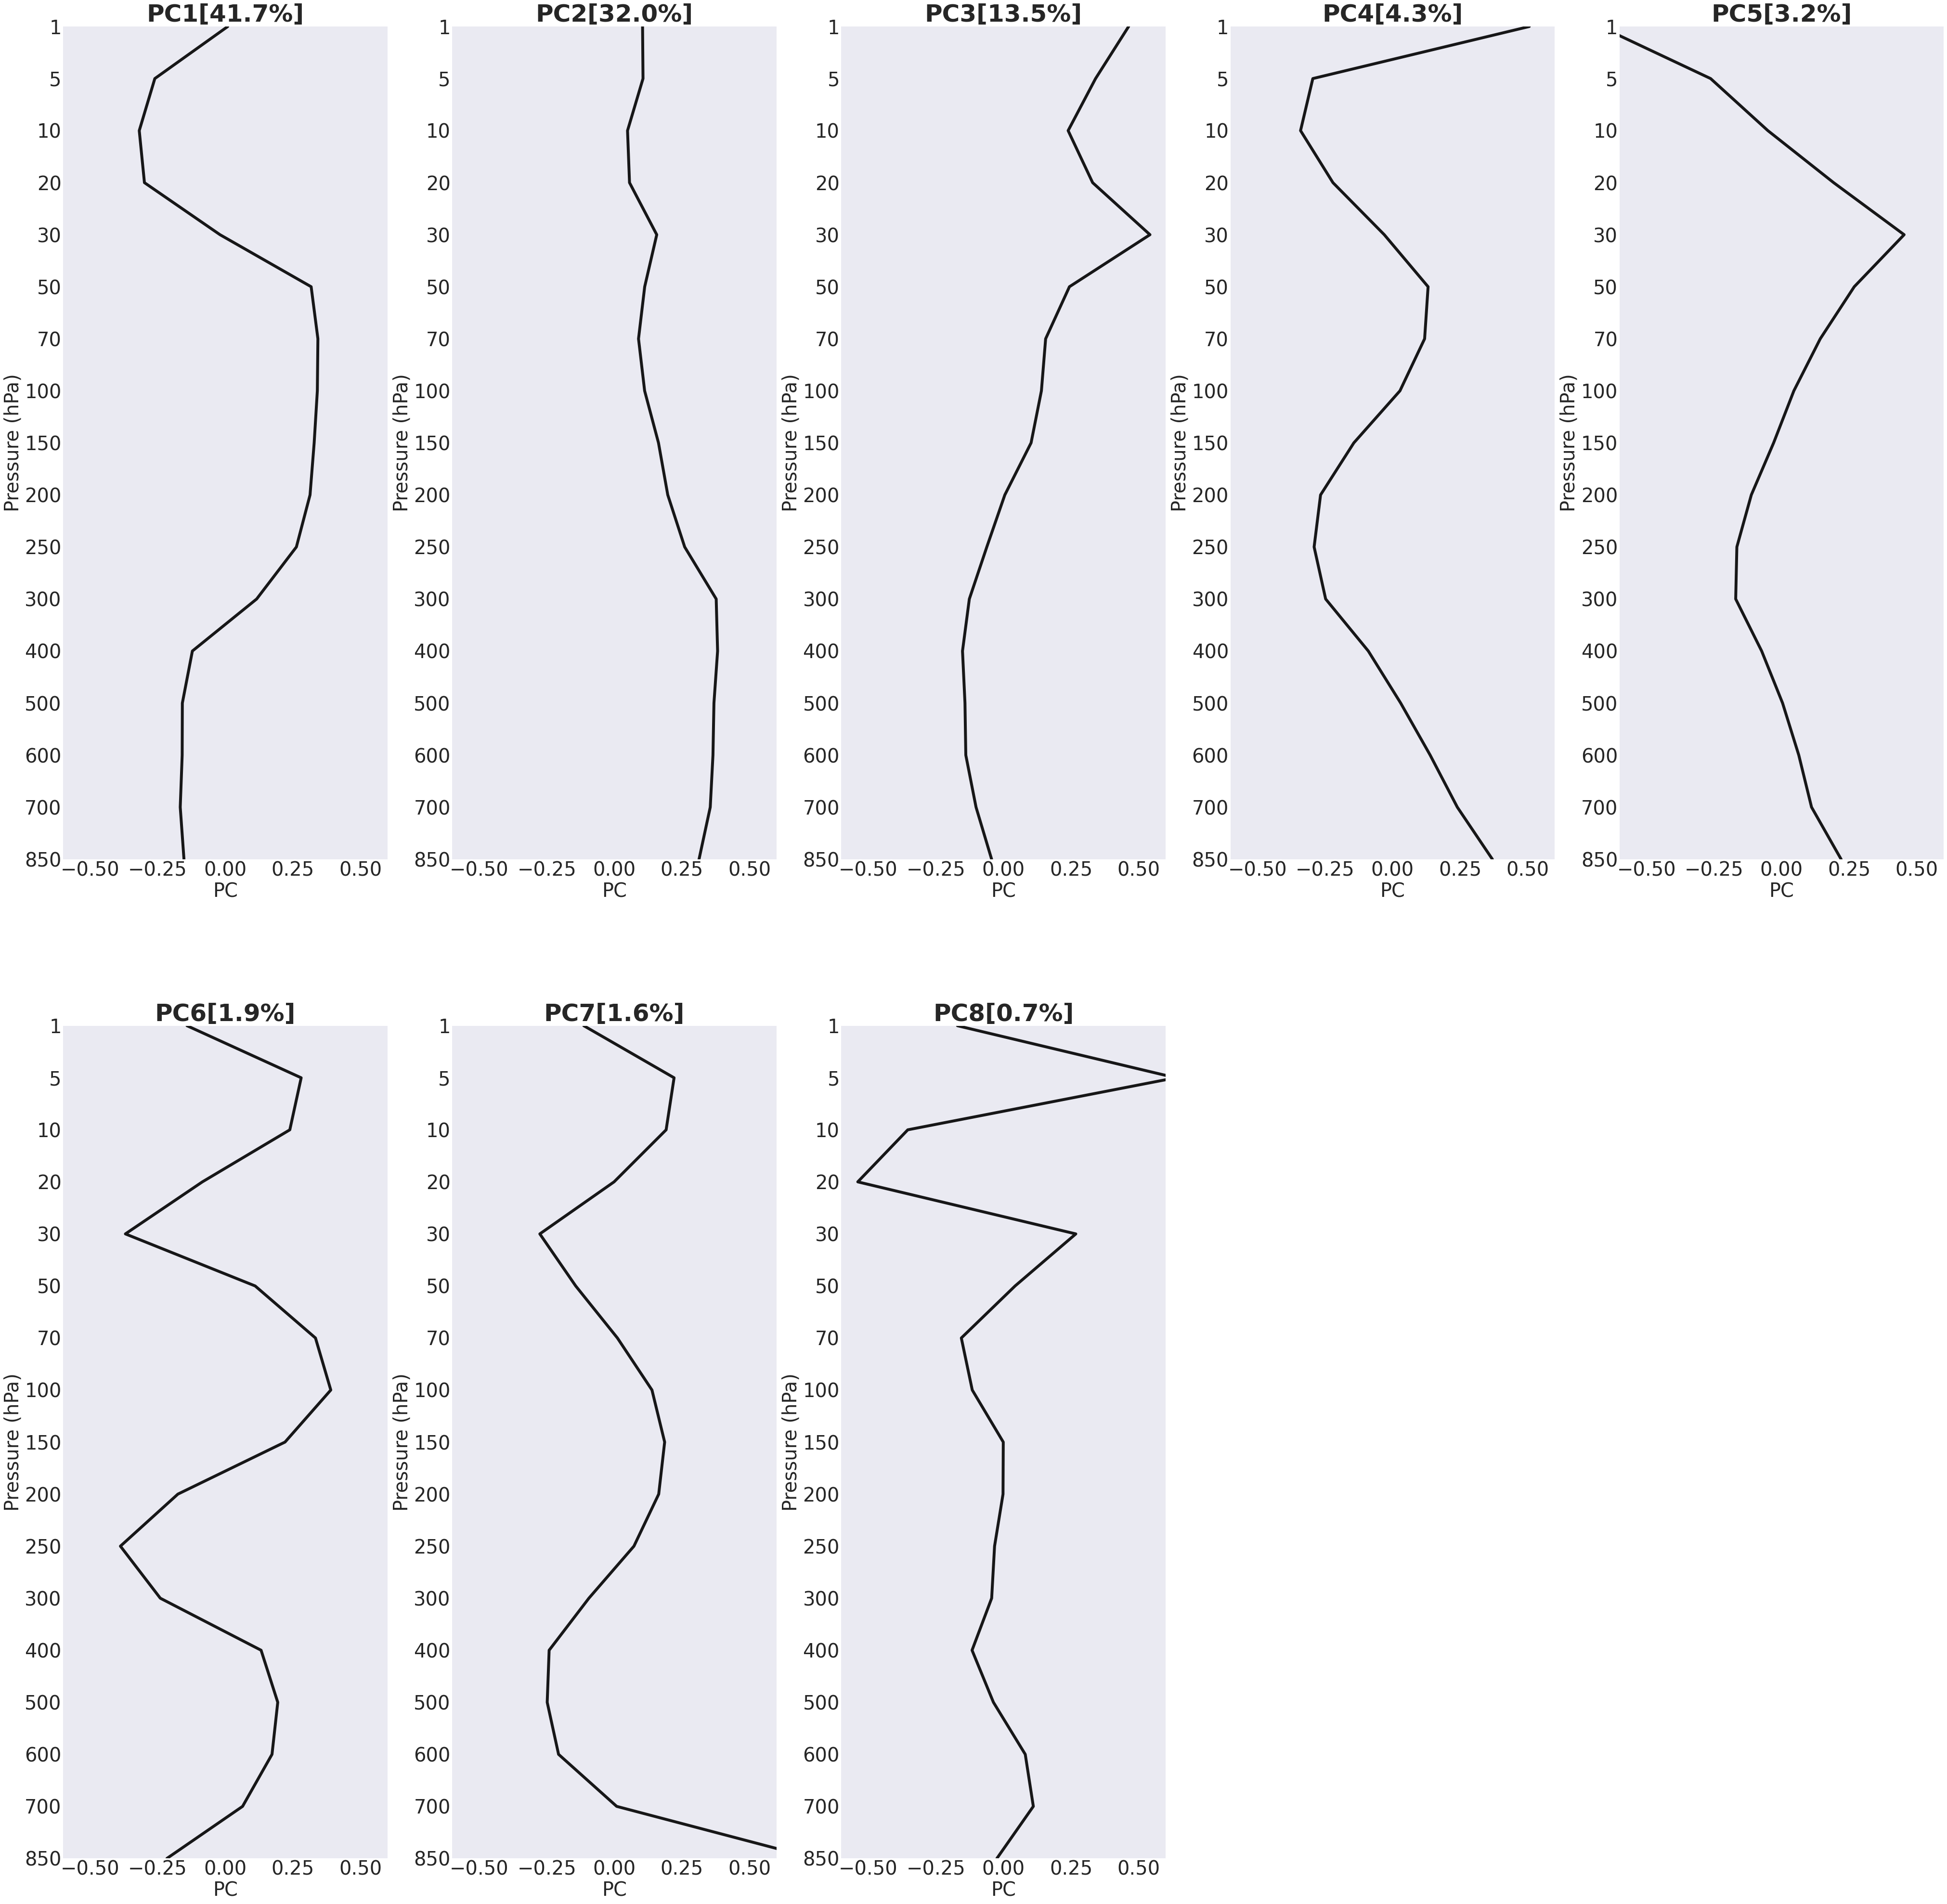

In [11]:
plt.figure(figsize = (70,70))
plt.style.use('seaborn-darkgrid')

num = 0

# iterate over groups
for npca in range(pca.n_components):
    num = num + 1
    
    # select subplot
    ax = plt.subplot(2,5,num)
    plt.plot(y1[npca,:], z, marker='', linestyle='solid',
                 color='black', linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    plt.grid()
    plt.ylim([min(z), z[0]])
    plt.xlim([-.6, .6])
    #text box
    fs = 24 # font size

    plt.xlabel('PC', fontsize=40)
    plt.ylabel('Pressure (hPa)', fontsize=40)
    plt.title('PC' + str(npca+1) + \
              '[' + str(round(pca.explained_variance_ratio_[npca]*100,1)) + '%]', fontsize=50, fontweight="bold")
              
                  
    # font and axis stuff
    plt.gca().invert_yaxis()
    ax.tick_params(axis='x', labelsize=40)
    ax.tick_params(axis='y', labelsize=40)
    # save figure and close
    #plt.savefig("figures/pca.pdf", bbox_inches='tight',dpi=300)

## Finding minimum BIC score for best Gaussian mixture model

In [12]:
# if file exists, then load it. Otherwise, calculate best GMM model
#mloc = '../../src/models/'
if os.path.isfile( 'models/n' + str(n_components_selected) + 'best_gmm_means.npy'):

    # set gmm_loaded flag to true
    gmm_loaded = True
    print('Found a GMM file, loading pre-fit GMM')
    
    # reload
    gmm_name = 'models/n' + str(n_components_selected) + 'best_gmm'
    means = np.load(gmm_name + '_means.npy')
    covar = np.load(gmm_name + '_covariances.npy')
    loaded_gmm = mixture.GaussianMixture(n_components = len(means), covariance_type='full')
    loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
    loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
    loaded_gmm.means_ = means
    loaded_gmm.covariances_ = covar
    best_gmm = loaded_gmm

else:
    
    # set gmm_loaded flag to true
    gmm_loaded = False
    
    # select parameters
    max_N = 30     # the maximum number of classes to try 
    max_bic_iter = 20  # the maximum number of iterations for BIC

    # initialise, declare variables
    lowest_bic = np.infty
    lowest_aic = np.infty
    bic_scores = np.zeros((2,max_bic_iter))
    aic_scores = np.zeros((2,max_bic_iter))
    silhouette_scores = np.zeros((2,max_bic_iter))

    # loop through the maximum number of classes, estimate BIC
    n_components_range = range(2, max_N)
    bic_iter_range = range(0,max_bic_iter)
    aic_iter_range = range(0,max_bic_iter)
    
    # iterate through all the covariance types (just 'full' for now)
    cv_types = ['full']
    
    for cv_type in cv_types:
        # iterate over all the possible numbers of components
        for n_components in n_components_range:
            
            # empty BIC and silhouette arrays
            bic_one = []
            aic_one = []
            sil_one = []
            
            # repeat the BIC step for better statistics
            for bic_iter in bic_iter_range:
                
                # select a new random subset
                rows_id = random.sample(range(0,Xpca.shape[0]-1), 1000)
                Xpca_for_BIC = Xpca[rows_id,:]
                
                # fit a Gaussian mixture model
                gmm = mixture.GaussianMixture(n_components=n_components,
                                              covariance_type=cv_type,
                                              random_state=42)

                # uncomment for 'rapid' BIC fitting
                gmm.fit(Xpca_for_BIC)
                # uncomment for 'full' BIC fitting
                #gmm.fit(Xpca)
                # append this BIC score to the list
                bic_one.append(gmm.bic(Xpca_for_BIC))
                aic_one.append(gmm.aic(Xpca_for_BIC))
                
                # get labels and silhouette score
                # The silhouette_score gives the average value for all the samples.
                # This gives a perspective into the density and separation of the formed
                # clusters
                cluster_labels_tmp = gmm.predict(Xpca_for_BIC)
                sil_tmp = silhouette_score(Xpca_for_BIC, cluster_labels_tmp)
                sil_one.append(sil_tmp)
                
                # clear this for the next BIC iteration
                Xpca_for_BIC = []
                
            # stack the bic and silhouette scores into a single 2D structure
            bic_scores = np.vstack((bic_scores, np.asarray(bic_one)))
            aic_scores = np.vstack((aic_scores, np.asarray(aic_one)))
            silhouette_scores = np.vstack((silhouette_scores, np.asarray(sil_one)))

    # BIC plot ----------------
            
    # the first two rows are not needed; they were only placeholders
    bic_scores = bic_scores[2:,:]

    # mean values for BIC
    bic_mean = np.mean(bic_scores, axis=1)

    # standard deviation for BIC
    bic_std = np.std(bic_scores, axis=1)

    # examine the mean bic values
    #bic_mean

    # plot the BIC scores
    plt.figure(figsize=(20, 8))
    plt.style.use('seaborn-darkgrid')
    spl = plt.subplot(2, 1, 1)
    plt.plot(n_components_range, bic_mean-bic_std, '--')  
    plt.plot(n_components_range, bic_mean, '-')  
    plt.plot(n_components_range, bic_mean+bic_std, '--')  
    plt.xticks(n_components_range)
    #plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model', fontsize=18)
    spl.set_xlabel('Number of components',fontsize=18)
    spl.set_ylabel('BIC score',fontsize=18)
    #plt.show()

    # save figure
    #plt.savefig(ploc+"BIC score per model (UKESM)",
    #           bbox_inches="tight",transparent=False)
    
    # AIC plot ----------------
            
    # the first two rows are not needed; they were only placeholders
    aic_scores = aic_scores[2:,:]

    # mean values for AIC
    aic_mean = np.mean(aic_scores, axis=1)

    # standard deviation for AIC
    aic_std = np.std(aic_scores, axis=1)

    # plot the AIC scores
    plt.figure(figsize=(20, 8))
    plt.style.use('seaborn-darkgrid')
    spl = plt.subplot(2, 1, 1)
    plt.plot(n_components_range, aic_mean-aic_std, '--')  
    plt.plot(n_components_range, aic_mean, '-')  
    plt.plot(n_components_range, aic_mean+aic_std, '--')  
    plt.xticks(n_components_range)
    #plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('AIC score per model', fontsize=18)
    spl.set_xlabel('Number of components',fontsize=18)
    spl.set_ylabel('AIC score',fontsize=18)
    #plt.show()

    # save figure
    #plt.savefig(ploc+"AIC score per model",
    #           bbox_inches="tight",transparent=False)
    
    # Silhouette score plot ----------------
            
    # the first two rows are not needed; they were only placeholders
    silhouette_scores = silhouette_scores[2:,:]

    # mean values for silhouette
    silhouette_mean = np.mean(silhouette_scores, axis=1)

    # standard deviation for silhouette
    silhouette_std = np.std(silhouette_scores, axis=1)

    # plot the silhouette scores
    plt.figure(figsize=(20, 8))
    plt.style.use('seaborn-darkgrid')
    spl = plt.subplot(2, 1, 1)
    plt.plot(n_components_range, silhouette_mean-silhouette_std, '--')  
    plt.plot(n_components_range, silhouette_mean, '-')  
    plt.plot(n_components_range, silhouette_mean+silhouette_std, '--')  
    plt.xticks(n_components_range)
    plt.title('Silhouette width per model', fontsize=18)
    spl.set_xlabel('Number of components',fontsize=18)
    spl.set_ylabel('Silhouette width',fontsize=18)

Found a GMM file, loading pre-fit GMM


In [13]:
# if the file exists, it should already be loaded. Print it out. 
if gmm_loaded==True:
    
    # print out best_gmm
    print('GMM has been pre-fit and it already loaded')
    best_gmm
    
else:
    
    # fit the "best" GMM model using the full Xpca dataset
    best_gmm = mixture.GaussianMixture(n_components=n_components_selected, 
                                       covariance_type='full', 
                                       random_state=42)
    best_gmm.fit(Xpca)
    # save to file
    gmm_name = 'models/n' + str(n_components_selected) + 'best_gmm' 
    np.save(gmm_name + '_weights', best_gmm.weights_, allow_pickle=False)
    np.save(gmm_name + '_means', best_gmm.means_, allow_pickle=False)
    np.save(gmm_name + '_covariances', best_gmm.covariances_, allow_pickle=False)

    
best_gmm

GMM has been pre-fit and it already loaded


GaussianMixture(n_components=6)

In [14]:
# assign class labels ("predict" the class using the selected GMM)
labels = best_gmm.predict(Xpca)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs = best_gmm.predict_proba(Xpca)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs = np.max(posterior_probs,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
df.insert(3,'label',labels,True)
df.insert(4,'max posterior prob',max_posterior_probs,True) 

# print out best_gmm parameters
df

x       y season  label  max posterior prob       850  \
0         0.9375 -89.375    DJF      4            1.000000  0.000000   
1         0.9375 -89.375    JJA      4            1.000000  0.000000   
2         0.9375 -89.375    MAM      4            1.000000  0.000000   
3         0.9375 -89.375    SON      4            1.000000  0.000000   
4         2.8125 -89.375    DJF      4            1.000000  0.000000   
...          ...     ...    ...    ...                 ...       ...   
428078  357.1875  89.375    MAM      5            1.000000  3.110951   
428079  357.1875  89.375    SON      2            1.000000  3.168741   
428080  359.0625  89.375    DJF      5            0.999994  2.790603   
428081  359.0625  89.375    JJA      2            1.000000  3.626347   
428082  359.0625  89.375    MAM      5            1.000000  3.110887   

             700       600       500       400  ...        200        150  \
0       0.099991  1.317870  1.275637  1.339549  ...   4.697723   4.587994   
1       0.039306  1.683980  1.477666  1.281533  ...   2.541174   5.368797   
2       0.038577  1.336666  1.227627  1.182483  ...   4.361568   5.909919   
3       0.074782  1.541470  1.391227  1.271945  ...   2.324337   4.662927   
4       0.098728  1.317713  1.275441  1.339394  ...   4.697357   4.587856   
...          ...       ...       ...       ...  ...        ...        ...   
428078  3.141170  3.029033  2.807894  2.675290  ...  12.147468  21.561138   
428079  3.109062  2.952354  2.708826  2.418583  ...   6.246322  10.505812   
428080  2.611595  2.489740  2.283158  2.044946  ...   5.133944  10.372397   
428081  3.869779  3.826420  3.700889  3.470816  ...  11.679680  17.567568   
428082  3.140643  3.028919  2.807747  2.675059  ...  12.140804  21.557773   

              100         70         50         30         20        10  \
0        5.397292   8.749182  12.559555  12.841137   9.390033  4.856805   
1       10.433466  16.512575  15.625815   9.196220   6.558020  2.781719   
2        9.756591  14.610302  15.168732  10.096333   6.584430  3.567123   
3        4.703378   4.604415   5.159846   6.753445   6.899643  4.422953   
4        5.396471   8.748376  12.558534  12.841625   9.391102  4.857012   
...           ...        ...        ...        ...        ...       ...   
428078  26.759465  26.567406  22.772397  16.389281  12.865323  7.441234   
428079  13.739154  16.610936  16.521086  12.498409   8.821268  5.321466   
428080  17.838699  21.718482  20.744612  15.345332  11.425738  6.518369   
428081  16.079520  16.266056  16.099107  12.749317   9.638267  5.780284   
428082  26.757580  26.567083  22.771342  16.387986  12.864750  7.441311   

               5         1  
0       2.673725  0.204272  
1       1.010234  0.169674  
2       1.779331  0.232079  
3       2.297504  0.221742  
4       2.673738  0.204271  
...          ...       ...  
428078  3.977507  0.346113  
428079  3.065838  0.351077  
428080  3.296892  0.278449  
428081  3.564140  0.263063  
428082  3.977551  0.346086  

[428083 rows x 22 columns]

In [15]:
# group by label
grouped_unsorted = df.groupby('label')

# calculate mean of all profiles in each class
df_means = grouped_unsorted.mean()
oz_means = df_means['y'].values
old2new = np.argsort(oz_means)

# create dictionary object for sorting
di = dict(zip(old2new,range(0,n_components_selected)))

# add new column to dataframe - sorted label
df.insert(4,'label_sorted',df['label'].map(di))

# examine dataframe
df

x       y season  label  label_sorted  max posterior prob  \
0         0.9375 -89.375    DJF      4             0            1.000000   
1         0.9375 -89.375    JJA      4             0            1.000000   
2         0.9375 -89.375    MAM      4             0            1.000000   
3         0.9375 -89.375    SON      4             0            1.000000   
4         2.8125 -89.375    DJF      4             0            1.000000   
...          ...     ...    ...    ...           ...                 ...   
428078  357.1875  89.375    MAM      5             4            1.000000   
428079  357.1875  89.375    SON      2             5            1.000000   
428080  359.0625  89.375    DJF      5             4            0.999994   
428081  359.0625  89.375    JJA      2             5            1.000000   
428082  359.0625  89.375    MAM      5             4            1.000000   

             850       700       600       500  ...        200        150  \
0       0.000000  0.099991  1.317870  1.275637  ...   4.697723   4.587994   
1       0.000000  0.039306  1.683980  1.477666  ...   2.541174   5.368797   
2       0.000000  0.038577  1.336666  1.227627  ...   4.361568   5.909919   
3       0.000000  0.074782  1.541470  1.391227  ...   2.324337   4.662927   
4       0.000000  0.098728  1.317713  1.275441  ...   4.697357   4.587856   
...          ...       ...       ...       ...  ...        ...        ...   
428078  3.110951  3.141170  3.029033  2.807894  ...  12.147468  21.561138   
428079  3.168741  3.109062  2.952354  2.708826  ...   6.246322  10.505812   
428080  2.790603  2.611595  2.489740  2.283158  ...   5.133944  10.372397   
428081  3.626347  3.869779  3.826420  3.700889  ...  11.679680  17.567568   
428082  3.110887  3.140643  3.028919  2.807747  ...  12.140804  21.557773   

              100         70         50         30         20        10  \
0        5.397292   8.749182  12.559555  12.841137   9.390033  4.856805   
1       10.433466  16.512575  15.625815   9.196220   6.558020  2.781719   
2        9.756591  14.610302  15.168732  10.096333   6.584430  3.567123   
3        4.703378   4.604415   5.159846   6.753445   6.899643  4.422953   
4        5.396471   8.748376  12.558534  12.841625   9.391102  4.857012   
...           ...        ...        ...        ...        ...       ...   
428078  26.759465  26.567406  22.772397  16.389281  12.865323  7.441234   
428079  13.739154  16.610936  16.521086  12.498409   8.821268  5.321466   
428080  17.838699  21.718482  20.744612  15.345332  11.425738  6.518369   
428081  16.079520  16.266056  16.099107  12.749317   9.638267  5.780284   
428082  26.757580  26.567083  22.771342  16.387986  12.864750  7.441311   

               5         1  
0       2.673725  0.204272  
1       1.010234  0.169674  
2       1.779331  0.232079  
3       2.297504  0.221742  
4       2.673738  0.204271  
...          ...       ...  
428078  3.977507  0.346113  
428079  3.065838  0.351077  
428080  3.296892  0.278449  
428081  3.564140  0.263063  
428082  3.977551  0.346086  

[428083 rows x 23 columns]

In [16]:
# max label
print("Number of clusters (prior to manual grouping)")
df.label_sorted.max()+1

Number of clusters (prior to manual grouping)


6

In [17]:
# classes 4 and 5 (python 3 and 4) are so similar that they swap easily
# classes 7 and 8 (python 6 and 7) are very similar

if manual_grouping==True:
    df0 = df
    for i in range(0,n_components_selected):
        df.loc[df0.label_sorted==i, "label_sorted"] = manual_classes[i]

# check to see the highest-valued label
print("Number of clusters (after manual grouping)")
df.label_sorted.max()+1

Number of clusters (after manual grouping)


6

In [18]:
# group profiles according to label
grouped = df.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means = grouped.mean()

# calculate stdevs of all profiles in each class
dfg_stds = grouped.std()

# number or profiles in each class
nprofs = grouped['x'].count().values

# count number of profiles at each location
gbl = df.groupby('x')
Al1=gbl.count()['label_sorted']
nprofs_ = Al1[df['x'].values].values

dfg_means

x          y  label  max posterior prob       850  \
label_sorted                                                               
0             198.166788 -73.367829    4.0            0.967185  0.953658   
1             184.524849 -34.489230    0.0            0.927495  2.135060   
2             179.231056   0.373760    1.0            0.961224  2.785962   
3             179.355687   3.366884    3.0            0.938810  3.088915   
4             188.840117  54.427790    5.0            0.967783  2.915950   
5             175.174692  69.547974    2.0            0.962118  2.928274   

                   700       600       500       400       300  ...       200  \
label_sorted                                                    ...             
0             1.364489  1.503543  1.404935  1.332333  1.564285  ...  4.629316   
1             2.075836  1.958980  1.797928  1.648175  1.838403  ...  4.672970   
2             2.809554  2.647682  2.487413  2.195107  1.693108  ...  1.186645   
3             3.259615  3.043697  2.766025  2.419367  2.089464  ...  2.462194   
4             2.902096  2.738079  2.513029  2.327420  2.798225  ...  8.241155   
5             3.183535  3.081067  2.874520  2.640896  2.855016  ...  7.092900   

                    150        100         70         50         30  \
label_sorted                                                          
0              8.019512  11.962313  14.331914  14.271809  11.979819   
1              7.506785  10.983852  14.185629  15.638599  14.199127   
2              1.133225   2.002528   5.042366   9.067398  13.507611   
3              3.297551   4.654014   7.495054  11.273379  14.281543   
4             13.114086  17.381807  19.706947  19.594237  15.853996   
5              9.925392  12.535822  14.758778  15.043603  12.510159   

                     20         10         5         1  
label_sorted                                            
0              9.602791   5.812524  3.040382  0.245983  
1             11.358875   6.781068  3.769071  0.318619  
2             14.981857  10.256451  4.577949  0.293493  
3             13.694243   9.050991  4.601556  0.291860  
4             12.078932   7.099536  3.851804  0.328660  
5              9.923675   6.159734  3.423539  0.287997  

[6 rows x 21 columns]

#### Colormap selection

In [19]:
colormap = plt.get_cmap('tab10', n_comp)

## We will start working with each data set with the same PCA calculated earlier

#### Historical data (2004-2014)

In [20]:
# keep 'data' as the unmodified historical original dataset
data_cleaned1 = data1

# drop rows with NaNs
data_cleaned1 = data_cleaned1.dropna()
data_cleaned1 = data_cleaned1.reset_index(drop=True)

#pressure values from the column headers
p1 = data_cleaned1.columns[3:].values

In [21]:
# let's work with the cleaned up historical datset dataset
df1 = data_cleaned1

# get the latitudes, and longitudes for each profile
lon = df1.iloc[:,0].values
lat = df1.iloc[:,1].values
season = df1.iloc[:,2].values

# get the array that will be used to fit the GMM object
X1 = df1.iloc[:,3:].values

# number of profiles for historical dataset
nProfiles1 = X1[:,1].size

# scale by variable 
Xscaled1 = preprocessing.scale(X1)

# check data frame
df1

x       y season       850       700       600       500  \
0         0.9375 -89.375    DJF  0.000000  0.099991  1.317870  1.275637   
1         0.9375 -89.375    JJA  0.000000  0.039306  1.683980  1.477666   
2         0.9375 -89.375    MAM  0.000000  0.038577  1.336666  1.227627   
3         0.9375 -89.375    SON  0.000000  0.074782  1.541470  1.391227   
4         2.8125 -89.375    DJF  0.000000  0.098728  1.317713  1.275441   
...          ...     ...    ...       ...       ...       ...       ...   
107007  357.1875  89.375    MAM  3.230198  3.135224  2.983059  2.779645   
107008  357.1875  89.375    SON  2.896052  2.879639  2.707690  2.485387   
107009  359.0625  89.375    DJF  2.664229  2.573197  2.385582  2.171925   
107010  359.0625  89.375    JJA  3.362948  3.493059  3.362510  3.148649   
107011  359.0625  89.375    MAM  3.230148  3.135341  2.983102  2.779502   

             400       300       250        200        150        100  \
0       1.339549  1.838563  2.986827   4.697723   4.587994   5.397292   
1       1.281533  1.196284  1.419046   2.541174   5.368797  10.433466   
2       1.182483  1.546504  2.580667   4.361568   5.909919   9.756591   
3       1.271945  1.259319  1.420209   2.324337   4.662927   4.703378   
4       1.339394  1.838222  2.986227   4.697357   4.587856   5.396471   
...          ...       ...       ...        ...        ...        ...   
107007  2.648739  3.460845  5.815338  10.281789  13.435838  15.727700   
107008  2.330671  2.823322  4.278940   6.844200   8.949165  12.810509   
107009  2.033299  2.443945  3.661988   6.613581  10.557016  15.837325   
107010  3.020113  3.715940  5.977703   9.595268  10.131558  12.424713   
107011  2.648755  3.460151  5.813962  10.280310  13.434521  15.725363   

               70         50         30         20        10         5  \
0        8.749182  12.559555  12.841137   9.390033  4.856805  2.673725   
1       16.512575  15.625815   9.196220   6.558020  2.781719  1.010234   
2       14.610302  15.168732  10.096333   6.584430  3.567123  1.779331   
3        4.604415   5.159846   6.753445   6.899643  4.422953  2.297504   
4        8.748376  12.558534  12.841625   9.391102  4.857012  2.673738   
...           ...        ...        ...        ...       ...       ...   
107007  16.843928  16.516593  13.484845  10.392876  5.967129  3.104414   
107008  15.039960  14.384839  10.861462   7.990345  4.569005  2.545042   
107009  18.236601  16.799602  12.196462   9.018058  5.059220  2.522020   
107010  14.435482  14.213897  10.573501   7.569845  4.970922  2.994963   
107011  16.841617  16.513288  13.483297  10.391918  5.967032  3.104364   

               1  
0       0.204272  
1       0.169674  
2       0.232079  
3       0.221742  
4       0.204271  
...          ...  
107007  0.275747  
107008  0.284012  
107009  0.272950  
107010  0.225944  
107011  0.275740  

[107012 rows x 20 columns]

In [22]:
# transform input data into PCA representation
Xpca1 = pca.transform(Xscaled1)

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
print("Total variance explained by principal component representation of dataset")
total_variance_explained_

Total variance explained by principal component representation of dataset


0.9885760933932282

In [23]:
# assign class labels ("predict" the class using the selected GMM)
labels1 = best_gmm.predict(Xpca1)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs1 = best_gmm.predict_proba(Xpca1)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs1 = np.max(posterior_probs1,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
df1.insert(3,'label',labels1,True)
df1.insert(4,'max posterior prob',max_posterior_probs1,True) 

# check data frame
print("Number of classes (before manual grouping)")
df1.label.max()+1

Number of classes (before manual grouping)


6

In [24]:
# group by label
grouped_unsorted1 = df1.groupby('label')

# calculate mean of all profiles in each class
df_means1 = grouped_unsorted1.mean()

oz_means1 = df_means1['y'].values

old2new1 = np.argsort(oz_means1)

# create dictionary object for sorting
di1 = dict(zip(old2new1,range(0,n_components_selected)))

# add new column to dataframe - sorted label
df1.insert(4,'label_sorted',df1['label'].map(di1))

In [25]:
grouped_unsorted1

In [26]:
# classes 4 and 5 (python 3 and 4) are so similar that they swap easily
# classes 7 and 8 (python 6 and 7) are very similar

if manual_grouping==True:
    df0 = df1
    for i in range(0,n_components_selected):
        df1.loc[df0.label_sorted==i, "label_sorted"] = manual_classes[i]

# check to see the highest-valued label
print("Number of classes (after manual grouping)")
df1.label_sorted.max()+1

Number of classes (after manual grouping)


6

In [27]:
# group profiles according to label
grouped1 = df1.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means1 = grouped1.mean()

# calculate stdevs of all profiles in each class
dfg_stds1 = grouped1.std()

# number or profiles in each class
nprofs1 = grouped1['x'].count().values

# count number of profiles at each location
gbl1 = df1.groupby('x')
Al1=gbl1.count()['label_sorted']
nprofs1_ = Al1[df1['x'].values].values
dfg_means1

x          y  label  max posterior prob       850  \
label_sorted                                                               
0             200.155071 -74.266381    4.0            0.944524  0.985765   
1             185.718437 -52.468453    0.0            0.941167  2.153867   
2             181.087670  -0.000342    1.0            0.940330  2.988442   
3             178.070218   3.480918    3.0            0.932505  3.360251   
4             190.255022  61.223379    5.0            0.955888  3.185123   
5             172.870545  69.108823    2.0            0.947686  2.942284   

                   700       600       500       400       300  ...       200  \
label_sorted                                                    ...             
0             1.400085  1.544462  1.437879  1.359616  1.570438  ...  3.884093   
1             2.066537  1.942956  1.778158  1.623591  1.775609  ...  4.171547   
2             2.918427  2.723142  2.545796  2.220228  1.705917  ...  1.226998   
3             3.462322  3.191597  2.861031  2.474818  2.119920  ...  2.400854   
4             3.142177  2.941861  2.683031  2.474924  2.972628  ...  8.149795   
5             3.152584  3.014733  2.780566  2.551112  2.809303  ...  6.613477   

                    150        100         70         50         30  \
label_sorted                                                          
0              5.503469   7.768655  10.821276  12.171097  11.086793   
1              6.277735   9.329077  12.818543  14.877395  13.889980   
2              1.216692   2.196523   5.331838   9.209994  13.586001   
3              3.009798   4.235983   7.096292  10.995341  14.117015   
4             11.443968  14.330168  16.678813  17.311994  14.736736   
5              8.648667  11.767435  14.227201  14.524694  12.198363   

                     20         10         5         1  
label_sorted                                            
0              8.895828   5.155781  2.614971  0.228081  
1             11.181845   6.607164  3.542066  0.295345  
2             15.054619  10.050370  4.281437  0.278882  
3             13.670467   8.843452  4.256981  0.277467  
4             11.418033   6.676929  3.520848  0.299693  
5              9.644315   5.839928  3.160162  0.276244  

[6 rows x 21 columns]

#### Plot the means and standard deviations of the classes by profile

In [28]:
dfg_means1

x          y  label  max posterior prob       850  \
label_sorted                                                               
0             200.155071 -74.266381    4.0            0.944524  0.985765   
1             185.718437 -52.468453    0.0            0.941167  2.153867   
2             181.087670  -0.000342    1.0            0.940330  2.988442   
3             178.070218   3.480918    3.0            0.932505  3.360251   
4             190.255022  61.223379    5.0            0.955888  3.185123   
5             172.870545  69.108823    2.0            0.947686  2.942284   

                   700       600       500       400       300  ...       200  \
label_sorted                                                    ...             
0             1.400085  1.544462  1.437879  1.359616  1.570438  ...  3.884093   
1             2.066537  1.942956  1.778158  1.623591  1.775609  ...  4.171547   
2             2.918427  2.723142  2.545796  2.220228  1.705917  ...  1.226998   
3             3.462322  3.191597  2.861031  2.474818  2.119920  ...  2.400854   
4             3.142177  2.941861  2.683031  2.474924  2.972628  ...  8.149795   
5             3.152584  3.014733  2.780566  2.551112  2.809303  ...  6.613477   

                    150        100         70         50         30  \
label_sorted                                                          
0              5.503469   7.768655  10.821276  12.171097  11.086793   
1              6.277735   9.329077  12.818543  14.877395  13.889980   
2              1.216692   2.196523   5.331838   9.209994  13.586001   
3              3.009798   4.235983   7.096292  10.995341  14.117015   
4             11.443968  14.330168  16.678813  17.311994  14.736736   
5              8.648667  11.767435  14.227201  14.524694  12.198363   

                     20         10         5         1  
label_sorted                                            
0              8.895828   5.155781  2.614971  0.228081  
1             11.181845   6.607164  3.542066  0.295345  
2             15.054619  10.050370  4.281437  0.278882  
3             13.670467   8.843452  4.256981  0.277467  
4             11.418033   6.676929  3.520848  0.299693  
5              9.644315   5.839928  3.160162  0.276244  

[6 rows x 21 columns]

Class1
Maximum at 50.0 hPa
Maximum ozone value of mean profile = 12.171096844141818
Standard deviation at level = 4.36087520399068
Class2
Maximum at 50.0 hPa
Maximum ozone value of mean profile = 14.87739543861922
Standard deviation at level = 2.620172520041728
Class3
Maximum at 20.0 hPa
Maximum ozone value of mean profile = 15.05461877363395
Standard deviation at level = 0.9491068729131706
Class4
Maximum at 30.0 hPa
Maximum ozone value of mean profile = 14.117014890375922
Standard deviation at level = 1.9224081255316192
Class5
Maximum at 50.0 hPa
Maximum ozone value of mean profile = 17.311993878683158
Standard deviation at level = 3.042089960597651
Class6
Maximum at 50.0 hPa
Maximum ozone value of mean profile = 14.524694133872453
Standard deviation at level = 2.276808759486596


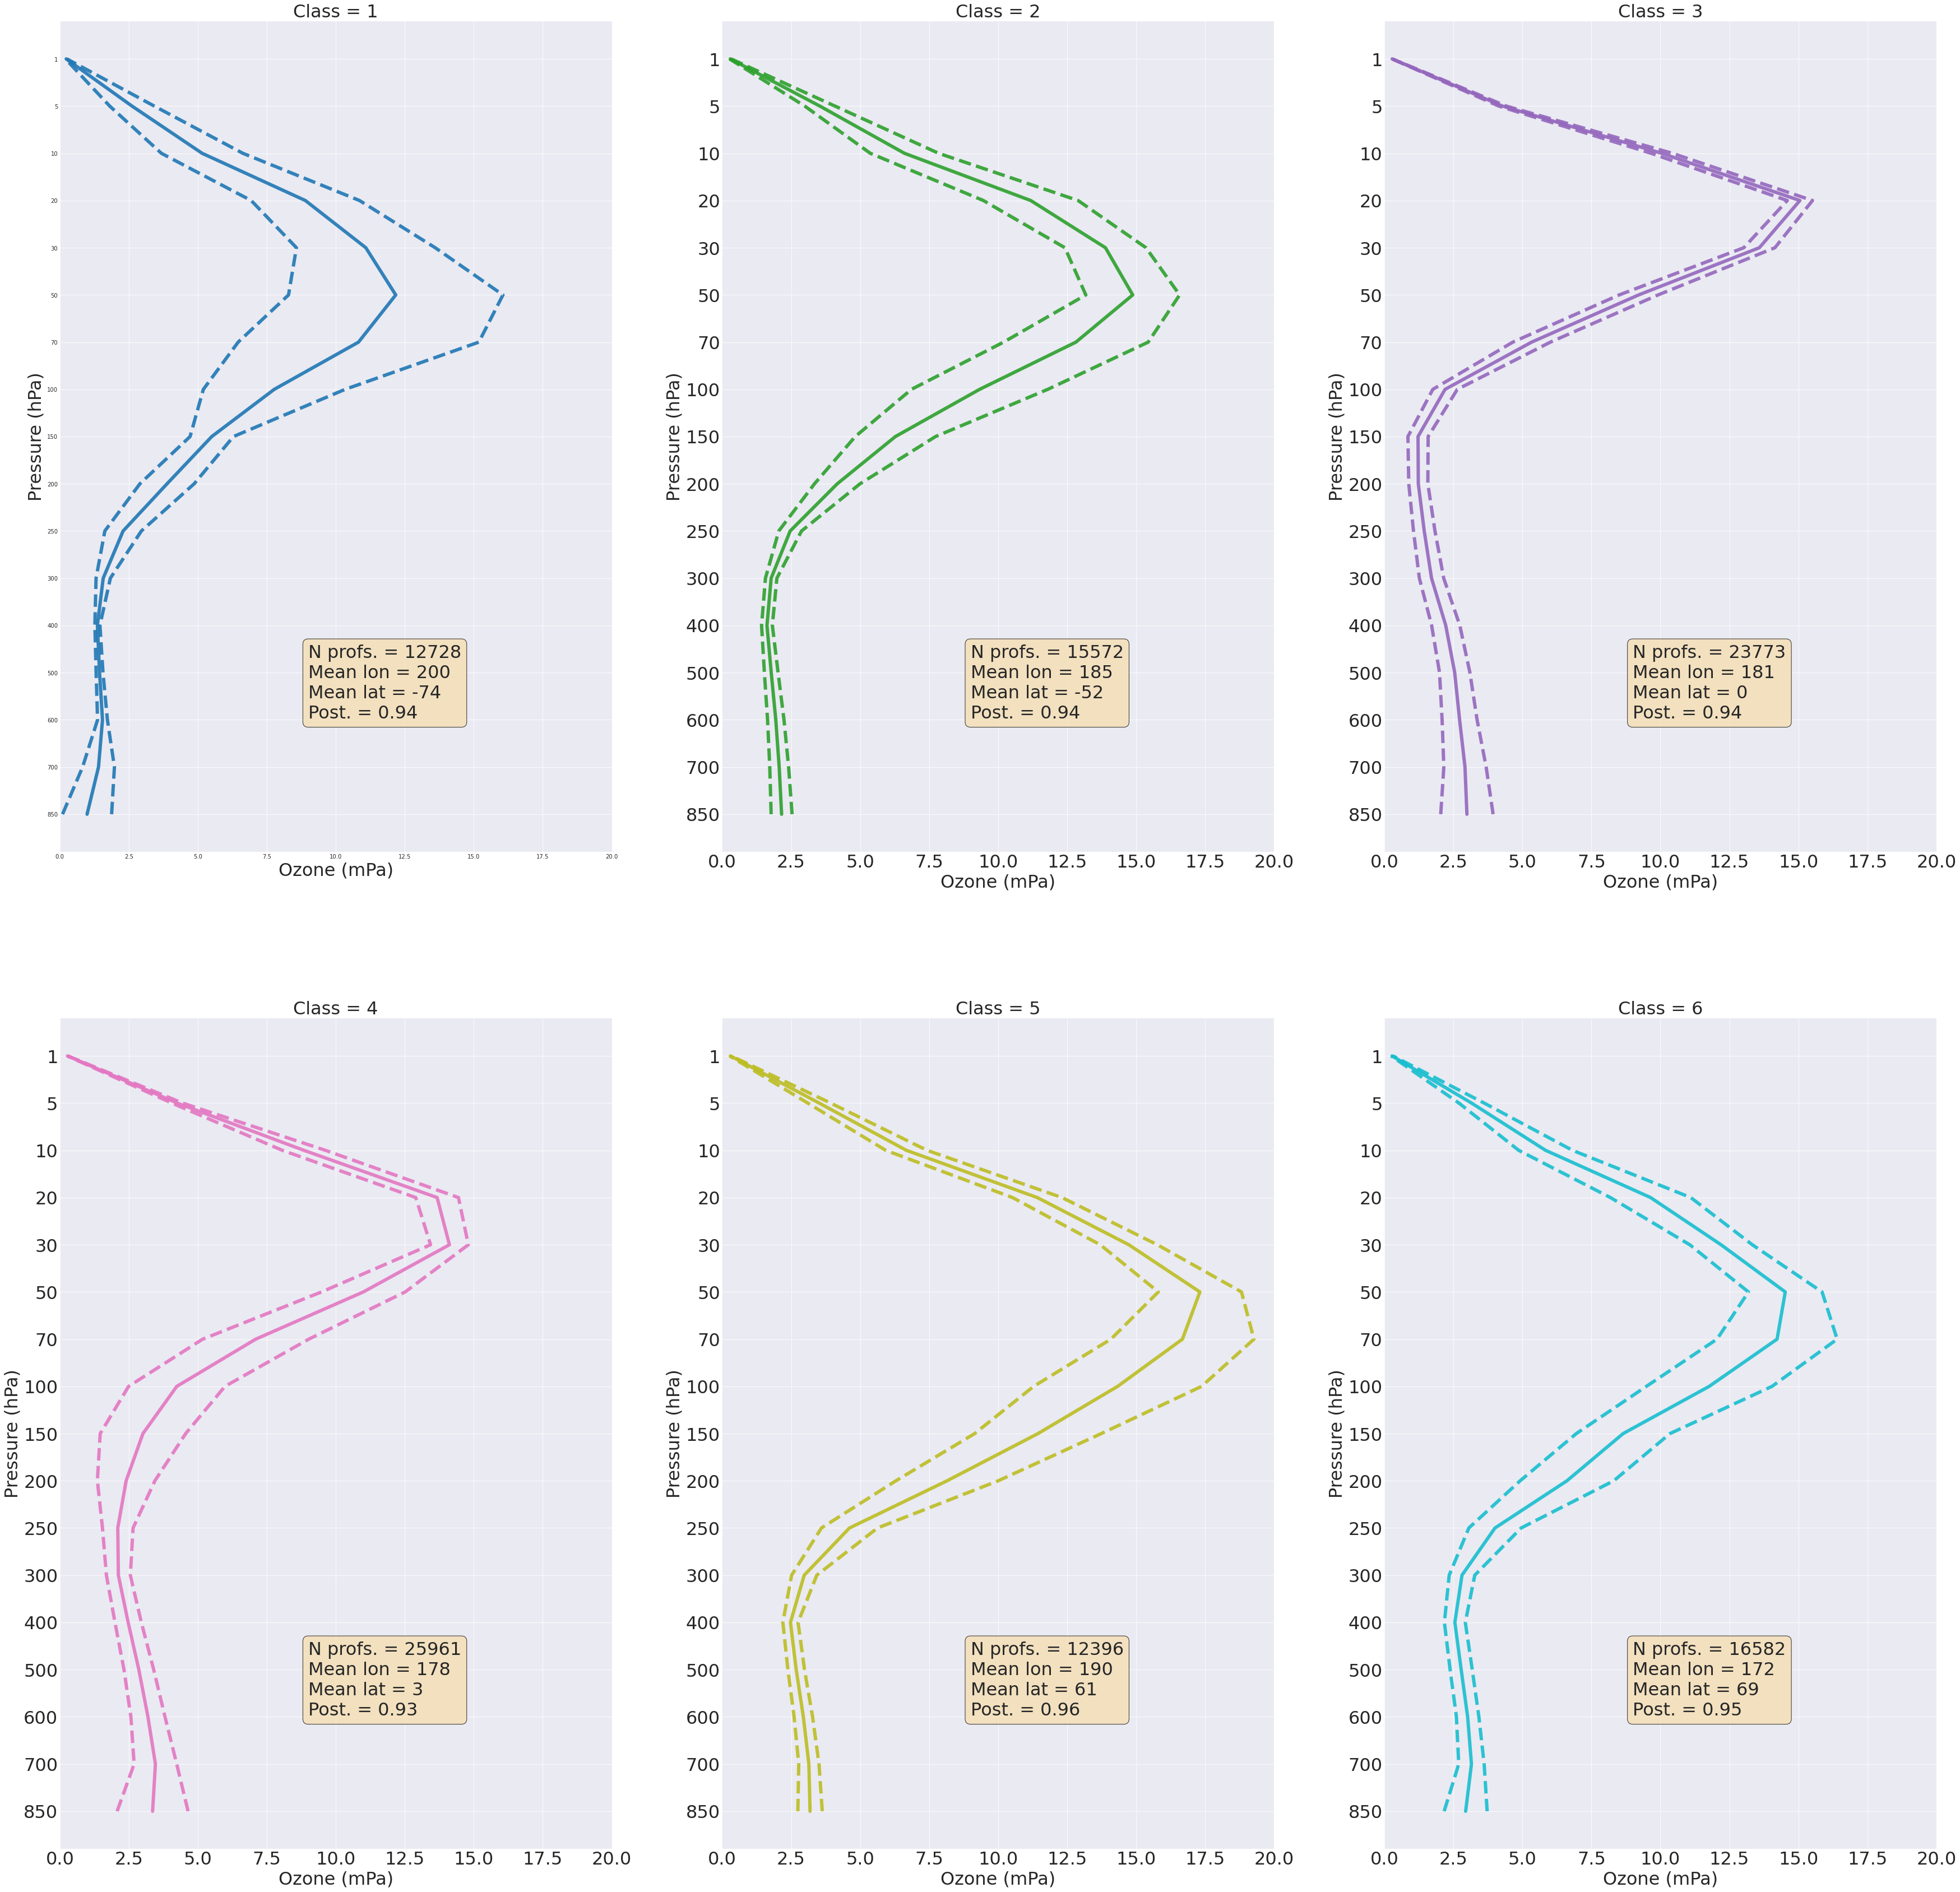

In [29]:
#classes for historical data set
cNorm = colors.Normalize(vmin=0, vmax=n_comp)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

max_ozone_pressure_hist = np.zeros(n_comp)
max_ozone_value_hist = np.zeros(n_comp)
std_ozone_value_hist = np.zeros(n_comp)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))
 
# iterate over groups
num = 0
for nrow in range(0,n_comp):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
     # extract means
    mean_lon1 = dfg_means1.iloc[nrow,0]
    mean_lat1 = dfg_means1.iloc[nrow,1]
    mean_maxpp1 = dfg_means1.iloc[nrow,3]
    mean_T1 = dfg_means1.iloc[nrow,4:].values
    
    # extract stdevs
    std_lon1 = dfg_stds1.iloc[nrow,0]
    std_lat1 = dfg_stds1.iloc[nrow,1]
    std_maxpp1 = dfg_stds1.iloc[nrow,3]
    std_T1 = dfg_stds1.iloc[nrow,4:].values
    
    # calculate it
    max_ozone_pressure_hist[nrow] = p[np.argmax(mean_T1)]
    max_ozone_value_hist[nrow] = np.max(mean_T1)
    std_ozone_value_hist[nrow] = np.max(std_T1)
    
    print('Class'+str(num))
    print('Maximum at ' + str(max_ozone_pressure_hist[nrow]) + ' hPa')
    print('Maximum ozone value of mean profile = ' + str(max_ozone_value_hist[nrow]))
    print('Standard deviation at level = ' + str(std_ozone_value_hist[nrow]))
    
    # select subplot
    #plt.subplot(np.ceil(n_comp/5),5,num)
    plt.subplot(int(np.ceil(n_comp/3)),3,num)
    plt.plot(mean_T1, p1, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T1+std_T1, p1, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T1-std_T1, p1, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    #plt.ylim([0,950])
    ax = plt.gca()
    #ax.invert_yaxis() 
    plt.xlim([0, 20])
    #ax.grid(True)
    
   #text box
    fs = 32 # font size
    plt.xlabel('Ozone (mPa)', fontsize=fs)
    plt.ylabel('Pressure (hPa)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    mpl.rc('xtick', labelsize=fs)     
    mpl.rc('ytick', labelsize=fs)
    
    # this creates the test boxes that display the class statistics
    textstr = '\n'.join((
        r'N profs. = %i' % (nprofs1[nrow], ),
        r'Mean lon = %i' % (mean_lon1, ),
        r'Mean lat = %i' % (mean_lat1, ),
        r'Post. = %.2f' % (mean_maxpp1, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    # place a text box in upper left in axes coords
    ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs,
            verticalalignment='top', bbox=props)   
   
   #plt.show()

# later, uncomment these to save the figures
plt.savefig("figures/historicalprofiles.pdf",
            bbox_inches="tight",transparent=False)

 

In the inset text boxes above, "N profs." is the number of profiles in each class. Also shown are class mean values for longitude, latitude, and maximum posterior probability.

In [30]:
df1

x       y season  label  label_sorted  max posterior prob  \
0         0.9375 -89.375    DJF      4             0            1.000000   
1         0.9375 -89.375    JJA      4             0            1.000000   
2         0.9375 -89.375    MAM      4             0            0.999949   
3         0.9375 -89.375    SON      4             0            1.000000   
4         2.8125 -89.375    DJF      4             0            1.000000   
...          ...     ...    ...    ...           ...                 ...   
107007  357.1875  89.375    MAM      5             4            0.998565   
107008  357.1875  89.375    SON      2             5            0.999999   
107009  359.0625  89.375    DJF      2             5            0.701567   
107010  359.0625  89.375    JJA      2             5            1.000000   
107011  359.0625  89.375    MAM      5             4            0.998547   

             850       700       600       500  ...        200        150  \
0       0.000000  0.099991  1.317870  1.275637  ...   4.697723   4.587994   
1       0.000000  0.039306  1.683980  1.477666  ...   2.541174   5.368797   
2       0.000000  0.038577  1.336666  1.227627  ...   4.361568   5.909919   
3       0.000000  0.074782  1.541470  1.391227  ...   2.324337   4.662927   
4       0.000000  0.098728  1.317713  1.275441  ...   4.697357   4.587856   
...          ...       ...       ...       ...  ...        ...        ...   
107007  3.230198  3.135224  2.983059  2.779645  ...  10.281789  13.435838   
107008  2.896052  2.879639  2.707690  2.485387  ...   6.844200   8.949165   
107009  2.664229  2.573197  2.385582  2.171925  ...   6.613581  10.557016   
107010  3.362948  3.493059  3.362510  3.148649  ...   9.595268  10.131558   
107011  3.230148  3.135341  2.983102  2.779502  ...  10.280310  13.434521   

              100         70         50         30         20        10  \
0        5.397292   8.749182  12.559555  12.841137   9.390033  4.856805   
1       10.433466  16.512575  15.625815   9.196220   6.558020  2.781719   
2        9.756591  14.610302  15.168732  10.096333   6.584430  3.567123   
3        4.703378   4.604415   5.159846   6.753445   6.899643  4.422953   
4        5.396471   8.748376  12.558534  12.841625   9.391102  4.857012   
...           ...        ...        ...        ...        ...       ...   
107007  15.727700  16.843928  16.516593  13.484845  10.392876  5.967129   
107008  12.810509  15.039960  14.384839  10.861462   7.990345  4.569005   
107009  15.837325  18.236601  16.799602  12.196462   9.018058  5.059220   
107010  12.424713  14.435482  14.213897  10.573501   7.569845  4.970922   
107011  15.725363  16.841617  16.513288  13.483297  10.391918  5.967032   

               5         1  
0       2.673725  0.204272  
1       1.010234  0.169674  
2       1.779331  0.232079  
3       2.297504  0.221742  
4       2.673738  0.204271  
...          ...       ...  
107007  3.104414  0.275747  
107008  2.545042  0.284012  
107009  2.522020  0.272950  
107010  2.994963  0.225944  
107011  3.104364  0.275740  

[107012 rows x 23 columns]

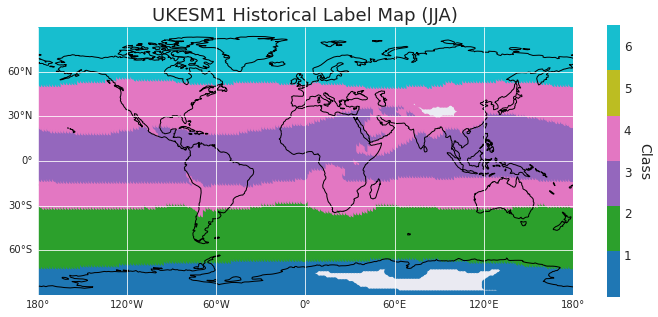

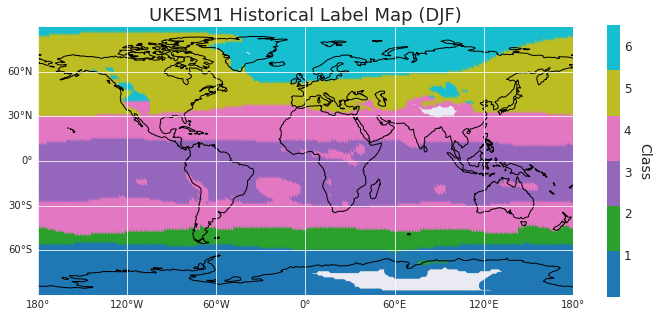

In [31]:
##### JJA

df1_season = df1[df1.season=="JJA"]
df1plot = df1_season.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

cplot = df1plot['label_sorted'].values + 1

CS1 = plt.scatter(df1plot['x'].values, df1plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 

colorbar = plt.colorbar(CS1, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('UKESM1 Historical Label Map (JJA)', fontsize=18) 
#plt.show()

# eventually, uncomment this in order to save the images
if save_figs==True:
    plt.savefig("figures/historical_labels",bbox_inches="tight",transparent=False)
    #figfolder = './'
    #plt.savefig(figfolder + "1.labels_historical",bbox_inches="tight",transparent=False)
    
##### DJF 

df1_season = df1[df1.season=="DJF"]
df1plot = df1_season.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

cplot = df1plot['label_sorted'].values + 1

CS1 = plt.scatter(df1plot['x'].values, df1plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 
colorbar = plt.colorbar(CS1, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('UKESM1 Historical Label Map (DJF)', fontsize=18) 
#plt.show()

# eventually, uncomment this in order to save the images
if save_figs==True:
    plt.savefig("figures/historical_labels_djf",bbox_inches="tight",transparent=False)
    #figfolder = './'
    #plt.savefig(figfolder + "1.labels_historical_djf",bbox_inches="tight",transparent=False)

#### PLot the label map for historical data

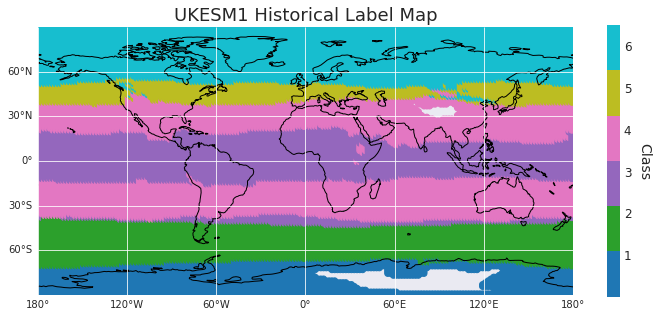

In [32]:
df1plot = df1.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

cplot = df1plot['label_sorted'].values + 1

CS1 = plt.scatter(df1plot['x'].values, df1plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 

colorbar = plt.colorbar(CS1, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('UKESM1 Historical Label Map', fontsize=18) 
#plt.show()

# eventually, uncomment this in order to save the images
#if save_figs==True:
plt.savefig("figures/historical_labels",bbox_inches="tight",transparent=False)
#figfolder = './'
#plt.savefig(figfolder + "1.labels_historical",bbox_inches="tight",transparent=False)



## Calculation of the area occupied by each class

In [33]:
x = df1['x'].values
y = df1['y'].values

In [34]:
df1['cos_lat'] = np.cos(np.radians(df1['y']))
A1 = df1.groupby('label_sorted').sum()['cos_lat']

In [35]:
#area calculation
area_hist = 100*A1/np.sum(A1)
area_hist

label_sorted
0     4.893251
1    13.420202
2    33.287578
3    31.949130
4     8.298411
5     8.151428
Name: cos_lat, dtype: float64

## We will repeat the process for future projection dataset

#### SSP1-2.6 (Annual mean from 2090-2100 with strong greenhouse emission reduction)

In [36]:
# keep 'data' as the unmodified original dataset
data_cleaned2 = data2 #ssp126

# drop rows with NaNs
data_cleaned2 = data_cleaned2.dropna()
data_cleaned2 = data_cleaned2.reset_index(drop=True)

# for simple plotting, extract an array of values 
A2 = data_cleaned2.drop(columns=['x','y']).values

In [37]:
# let's work with the cleaned up dataset
df2 = data_cleaned2

# get the latitudes, and longitudes for each profile
lon = df2.iloc[:,0].values
lat = df2.iloc[:,1].values
season = df2.iloc[:,2].values

# get the array that will be used to fit the GMM object
X2 = df2.iloc[:,3:].values

# number of profiles
nProfiles2 = X2[:,1].size
nProfiles2
# scale by variable
Xscaled2 = preprocessing.scale(X2)

In [38]:
# transform input data into PCA representation
Xpca2 = pca.transform(Xscaled2)

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
total_variance_explained_

0.9885760933932282

In [39]:
# assign class labels ("predict" the class using the selected GMM)
labels2 = best_gmm.predict(Xpca2)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs2 = best_gmm.predict_proba(Xpca2)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs2 = np.max(posterior_probs2,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
df2.insert(3,'label',labels2,True)
df2.insert(4,'max posterior prob',max_posterior_probs2,True)

In [40]:
# group by label
grouped_unsorted2 = df2.groupby('label')

# calculate mean of all profiles in each class
df_means2 = grouped_unsorted2.mean()

# extrat ozone values 
oz_means2 = df_means2['y'].values

old2new2 = np.argsort(oz_means2)

# create dictionary object for sorting
di2 = dict(zip(old2new2,range(0,n_components_selected )))

# add new column to dataframe - sorted label
df2.insert(4,'label_sorted',df2['label'].map(di2))

In [41]:
# classes 7 and 8 (python 6 and 7) are very similar

if manual_grouping==True:
    df0 = df2
    for i in range(0,n_components_selected):
        df2.loc[df0.label_sorted==i, "label_sorted"] = manual_classes[i]

# check to see the highest-valued label
print("Number of classes xin this model")
df2.label_sorted.max()+1

Number of classes xin this model


6

In [42]:
# group profiles according to label
grouped2 = df2.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means2 = grouped2.mean()

# calculate stdevs of all profiles in each class
dfg_stds2 = grouped2.std()

# number or profiles in each class
nprofs2 = grouped2['x'].count().values

In [43]:
dfg_means2

x          y  label  max posterior prob       850  \
label_sorted                                                               
0             196.740282 -73.308212    4.0            0.978999  0.900583   
1             181.578458 -33.376030    0.0            0.919223  1.981598   
2             180.629837  -0.090478    1.0            0.934585  2.212560   
3             178.364219   2.380500    3.0            0.933152  2.616504   
4             186.980251  61.759695    5.0            0.959182  2.312950   
5             182.261731  64.449878    2.0            0.917220  2.249089   

                   700       600       500       400       300  ...       200  \
label_sorted                                                    ...             
0             1.266561  1.387129  1.297271  1.251124  1.604217  ...  5.787956   
1             1.921131  1.818240  1.677373  1.564422  1.872955  ...  5.519689   
2             2.255665  2.147214  2.065425  1.839603  1.400062  ...  0.976152   
3             2.820207  2.651721  2.417528  2.108822  1.816150  ...  2.212620   
4             2.339111  2.233653  2.086276  2.013143  2.802552  ...  9.568408   
5             2.492860  2.435797  2.292292  2.134575  2.463000  ...  7.290536   

                    150        100         70         50         30  \
label_sorted                                                          
0             10.232173  15.402432  17.195404  15.841869  12.280122   
1              9.005521  13.010452  16.068482  16.705623  14.240456   
2              0.960503   1.977982   5.608403   9.869756  14.152076   
3              3.023307   4.467984   7.793219  11.890225  14.653675   
4             14.454476  18.532646  20.666652  20.262587  15.865935   
5             10.272919  13.605725  16.034269  15.872940  12.564789   

                     20        10         5         1  
label_sorted                                           
0              9.605868  5.899318  3.119478  0.256319  
1             11.046671  6.616330  3.790503  0.339025  
2             15.320958  9.986575  4.516877  0.299414  
3             13.861322  9.002145  4.585171  0.300021  
4             11.790215  7.000750  3.860852  0.341724  
5              9.963314  6.253671  3.531786  0.307883  

[6 rows x 21 columns]

In [44]:
# count number of profiles at each location
gbl2 = df2.groupby('x')
Al2 =gbl2.count()['label_sorted']
nprofs2_ = Al2[df2['x'].values].values

#### Plot the means and standard deviations of the classes by profile

Class1
Maximum at 70.0 hPa
Maximum ozone value of mean profile = 17.195403846566645
Standard deviation at level = 2.4480187214911306
Class2
Maximum at 50.0 hPa
Maximum ozone value of mean profile = 16.705623005925027
Standard deviation at level = 3.183500799833359
Class3
Maximum at 20.0 hPa
Maximum ozone value of mean profile = 15.320958038949973
Standard deviation at level = 0.8606559841837189
Class4
Maximum at 30.0 hPa
Maximum ozone value of mean profile = 14.653674647919829
Standard deviation at level = 2.6419455100647045
Class5
Maximum at 70.0 hPa
Maximum ozone value of mean profile = 20.66665210912394
Standard deviation at level = 4.444969076072393
Class6
Maximum at 70.0 hPa
Maximum ozone value of mean profile = 16.03426926589194
Standard deviation at level = 2.9937382117544162


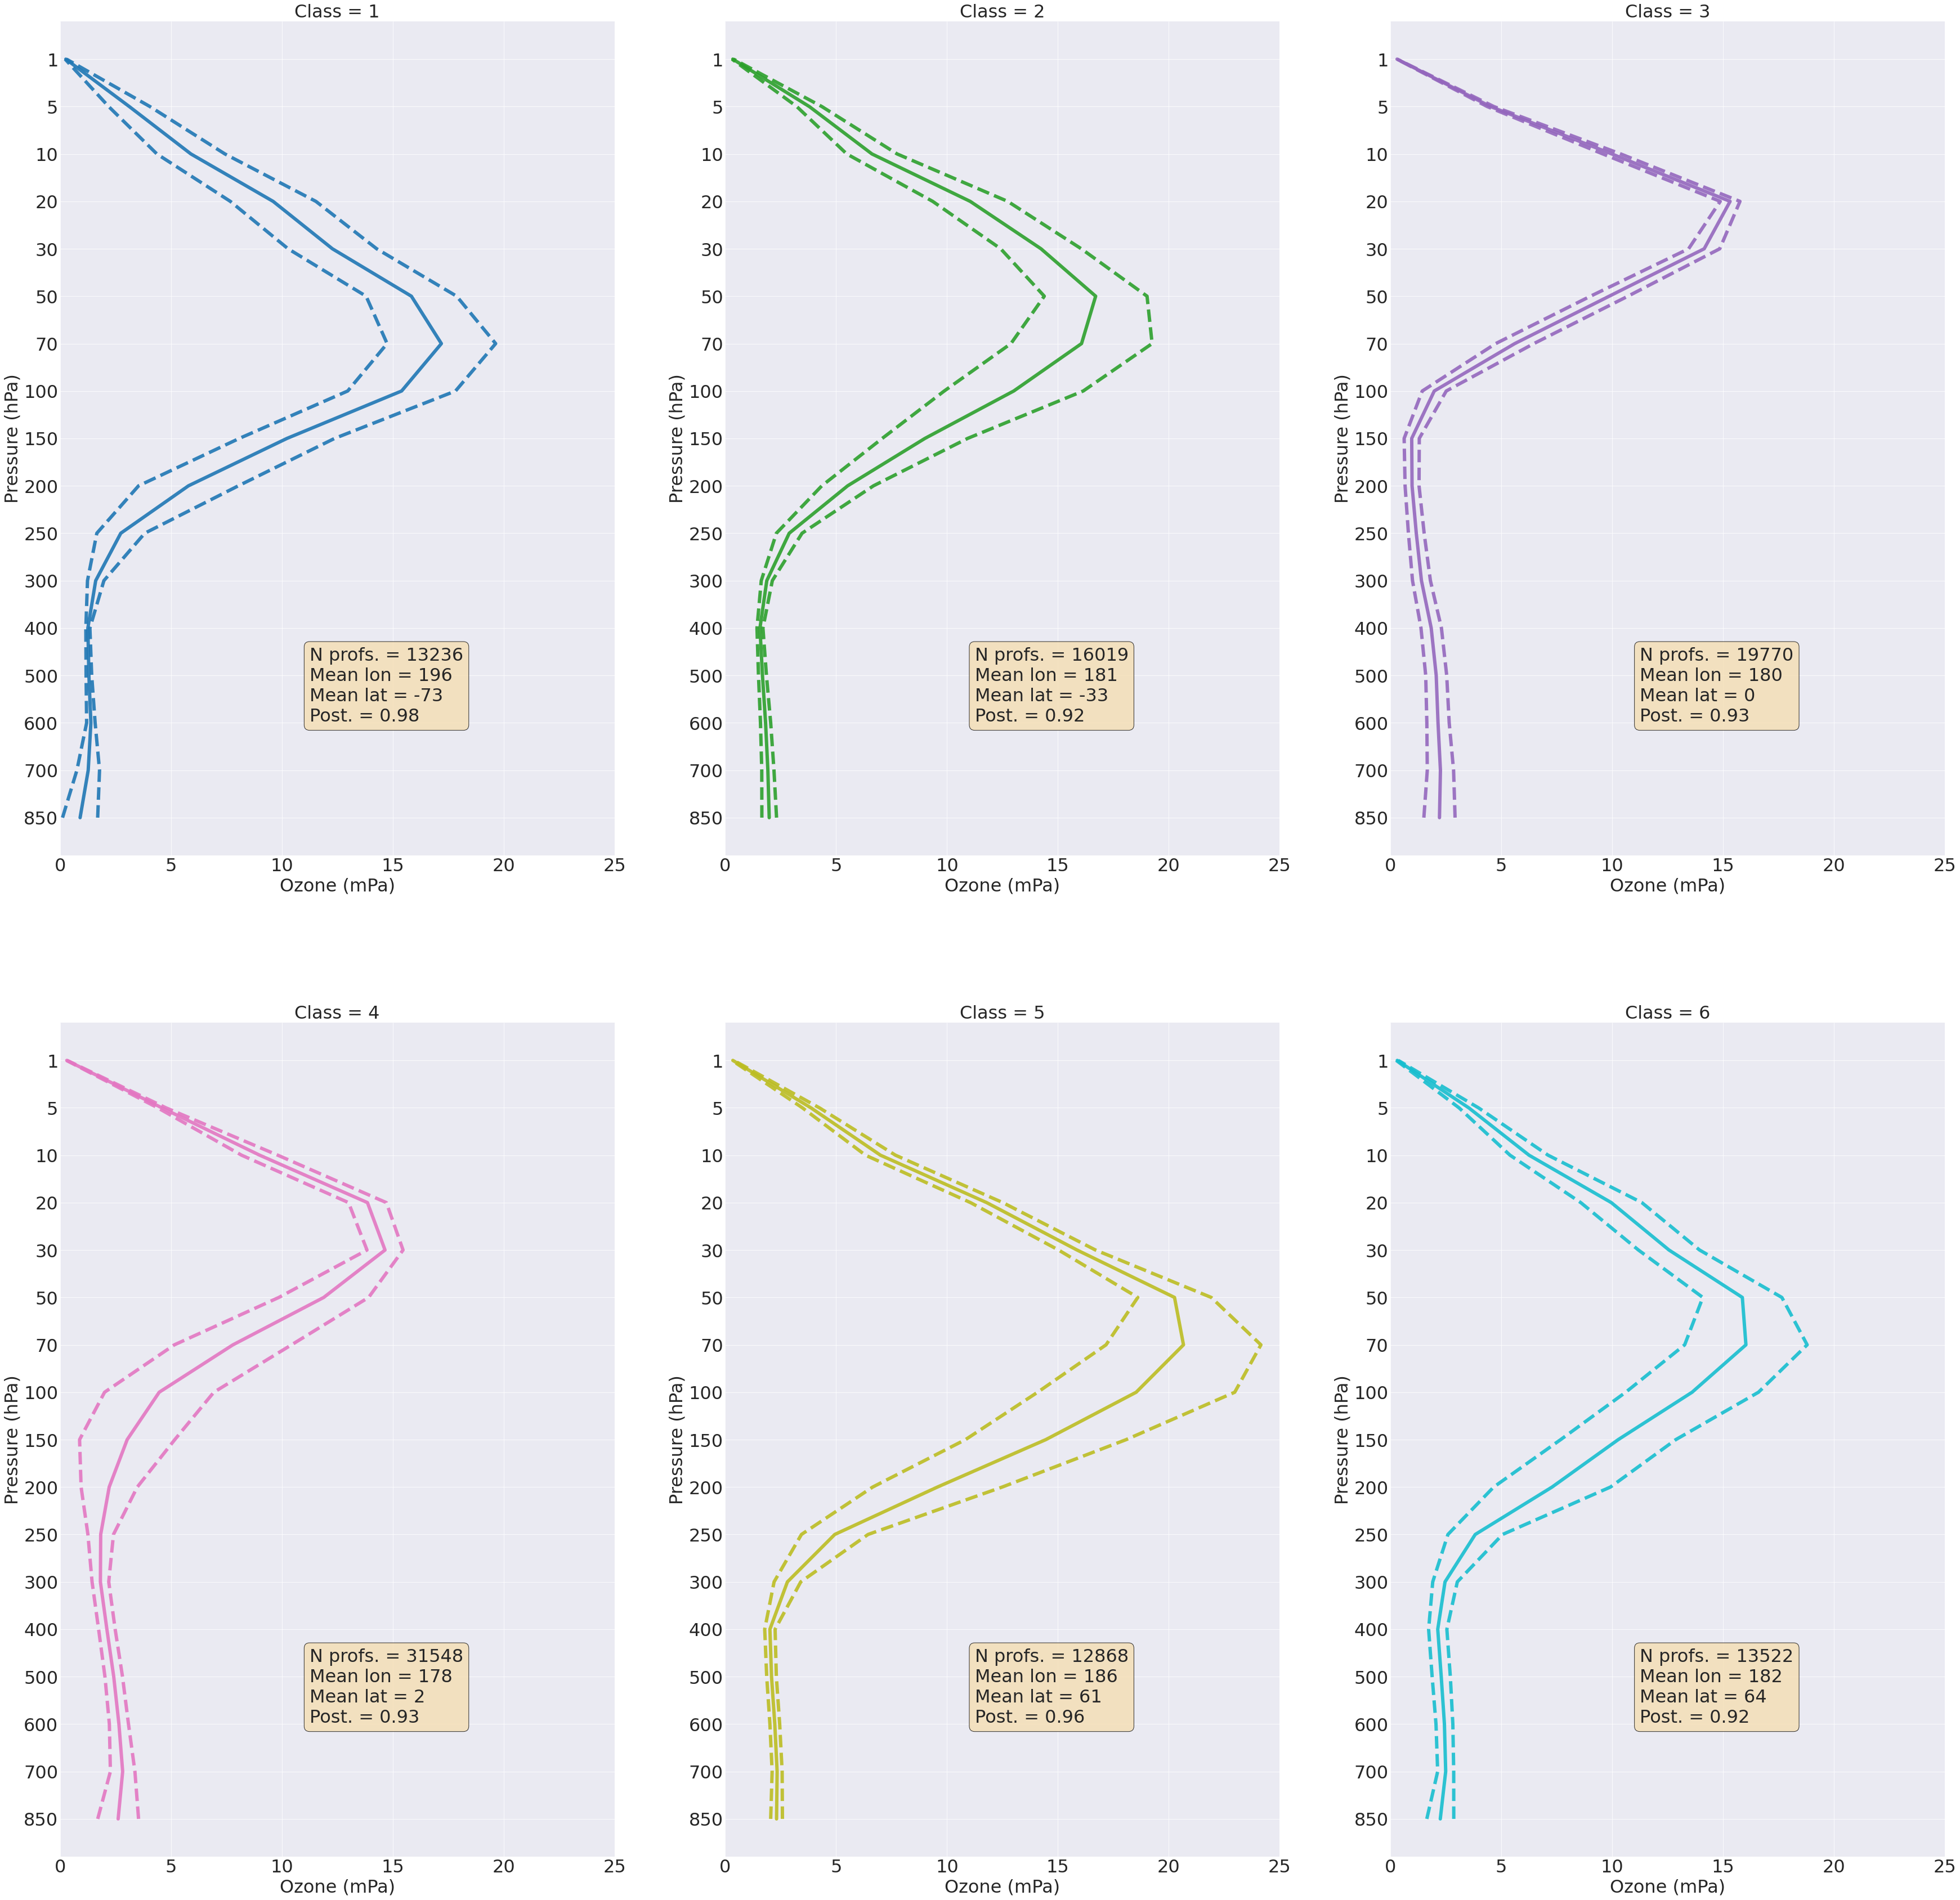

In [45]:
cNorm = colors.Normalize(vmin=0, vmax=n_comp)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))

# declare arrays
max_ozone_pressure_ssp126 = np.zeros(n_comp)
max_ozone_value_ssp126 = np.zeros(n_comp)
std_ozone_value_ssp126 = np.zeros(n_comp)
 
# iterate over groups
num = 0
for nrow in range(0,n_comp):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
     # extract means
    mean_lon2 = dfg_means2.iloc[nrow,0]
    mean_lat2 = dfg_means2.iloc[nrow,1]
    mean_maxpp2 = dfg_means2.iloc[nrow,3]
    mean_T2 = dfg_means2.iloc[nrow,4:].values
    
    # extract stdevs
    std_lon2 = dfg_stds2.iloc[nrow,0]
    std_lat2 = dfg_stds2.iloc[nrow,1]
    std_maxpp2 = dfg_stds2.iloc[nrow,3]
    std_T2 = dfg_stds2.iloc[nrow,4:].values
    
    # calculate it
    max_ozone_pressure_ssp126[nrow] = p[np.argmax(mean_T2)]
    max_ozone_value_ssp126[nrow] = np.max(mean_T2)
    std_ozone_value_ssp126[nrow] = np.max(std_T2)
    
    print('Class'+str(num))
    print('Maximum at ' + str(max_ozone_pressure_ssp126[nrow]) + ' hPa')
    print('Maximum ozone value of mean profile = ' + str(max_ozone_value_ssp126[nrow]))
    print('Standard deviation at level = ' + str(std_ozone_value_ssp126[nrow]))
    
    # select subplot
    #plt.subplot(np.ceil(n_comp/5),5,num)
    plt.subplot(int(np.ceil(n_comp/3)),3,num)
    plt.plot(mean_T2, p1, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T2+std_T2, p1, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T2-std_T2, p1, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    #plt.ylim([0,950])
    ax = plt.gca()
    #ax.invert_yaxis() 
    plt.xlim([0, 25])
    #ax.grid(True)
    
   #text box
    fs = 32 # font size
    plt.xlabel('Ozone (mPa)', fontsize=fs)
    plt.ylabel('Pressure (hPa)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    mpl.rc('xtick', labelsize=fs)     
    mpl.rc('ytick', labelsize=fs)
    
    # this creates the test boxes that display the class statistics
    textstr = '\n'.join((
        r'N profs. = %i' % (nprofs2[nrow], ),
        r'Mean lon = %i' % (mean_lon2, ),
        r'Mean lat = %i' % (mean_lat2, ),
        r'Post. = %.2f' % (mean_maxpp2, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    # place a text box in upper left in axes coords
    ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs,
            verticalalignment='top', bbox=props)   
   #plt.show()

# later, uncomment these to save the figures
plt.savefig("figures/ssp126profiles.pdf",
           bbox_inches="tight",transparent=False)

In the inset text boxes above, "N profs." is the number of profiles in each class. Also shown are class mean values for longitude, latitude, and maximum posterior probability.

#### Plot the label map

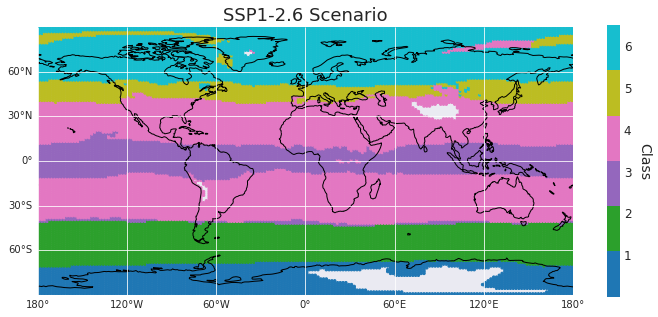

In [46]:
#colormap with carbon emission reduction (SSP126)

# median label
df2plot = df2.groupby(['x','y']).median().reset_index()
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
#ax.stock_img()
ax.coastlines()

cplot = df2plot['label_sorted'].values + 1

CS2 = plt.scatter(df2plot['x'].values, df2plot['y'].values, c=cplot,
                 marker='o',cmap= colormap, s=6.0,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 #)

colorbar = plt.colorbar(CS2, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)
colorbar.ax.tick_params(labelsize='large')
plt.title('SSP1-2.6 Scenario', fontsize=18) 
#plt.show()

# eventually, uncomment this in order to save the images#if save_figs==True:
plt.savefig("figures/ssp126_labels",bbox_inches="tight",transparent=False)

#### Area calculation

In [47]:
df2['cos_lat'] = np.cos(np.radians(df2['y']))
A2 = df2.groupby('label_sorted').sum()['cos_lat']
area_ssp126 = 100*A2/np.sum(A2)
area_ssp126

label_sorted
0     5.349368
1    12.168625
2    27.736691
3    39.302757
4     8.476681
5     6.965878
Name: cos_lat, dtype: float64

#### SSP5-8.5 (Annual mean from 2090-2100 with no greenhouse emission reduction)

In [48]:
# keep 'data' as the unmodified original dataset
data_cleaned3 = data3 #ssp585

# drop rows with NaNs
data_cleaned3 = data_cleaned3.dropna()
data_cleaned3 = data_cleaned3.reset_index(drop=True)

# let's work with the cleaned up dataset
df3 = data_cleaned3

# get the latitudes, and longitudes for each profile
lon = df3.iloc[:,0].values
lat = df3.iloc[:,1].values
season = df3.iloc[:,2].values

# get the array that will be used to fit the GMM object
X3 = df3.iloc[:,3:].values

# number of profiles
nProfiles3 = X3[:,1].size
nProfiles3
# scale by variable
Xscaled3 = preprocessing.scale(X3)

In [49]:
# transform input data into PCA representation
Xpca3 = pca.transform(Xscaled3)

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
total_variance_explained_

# select colormap
#colormap = plt.get_cmap('rainbow', n_comp)

# assign class labels ("predict" the class using the selected GMM)
labels3 = best_gmm.predict(Xpca3)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs3 = best_gmm.predict_proba(Xpca3)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs3 = np.max(posterior_probs3,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
df3.insert(3,'label',labels3,True)
df3.insert(4,'max posterior prob',max_posterior_probs3,True)

In [50]:
# group by label
grouped_unsorted3 = df3.groupby('label')

# calculate mean of all profiles in each class
df_means3 = grouped_unsorted3.mean()

oz_means3 = df_means3['y'].values

old2new3 = np.argsort(oz_means3)

# create dictionary object for sorting
di3 = dict(zip(old2new3,range(0,n_components_selected)))

# add new column to dataframe - sorted label
df3.insert(4,'label_sorted',df3['label'].map(di3))


In [51]:
# classes 7 and 8 (python 6 and 7) are very similar

if manual_grouping==True:
    df0 = df3
    for i in range(0,n_components_selected):
        df3.loc[df0.label_sorted==i, "label_sorted"] = manual_classes[i]

# check to see the highest-valued label
print("Number of classes (after manual grouping)")
df3.label_sorted.max()+1

Number of classes (after manual grouping)


6

In [52]:
# group profiles according to label
grouped3 = df3.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means3 = grouped3.mean()

# calculate stdevs of all profiles in each class
dfg_stds3 = grouped3.std()

# number or profiles in each class
nprofs3 = grouped3['x'].count().values

In [53]:
dfg_means3

x          y  label  max posterior prob       850  \
label_sorted                                                               
0             194.128003 -71.742536    4.0            0.984343  1.043887   
1             190.094912 -50.215246    0.0            0.917917  2.162677   
2             180.137681   0.708815    1.0            0.936314  2.558622   
3             178.850222   2.829444    3.0            0.932092  3.190353   
4             181.822213  45.749637    5.0            0.981217  3.004362   
5             179.975824  67.924702    2.0            0.975615  3.291983   

                   700       600       500       400       300  ...       200  \
label_sorted                                                    ...             
0             1.432181  1.560324  1.462679  1.369356  1.513023  ...  4.730047   
1             2.177835  2.090938  1.949769  1.796809  1.922014  ...  4.655458   
2             2.722043  2.639556  2.526495  2.310014  1.803889  ...  1.179061   
3             3.420885  3.229764  2.984295  2.639548  2.220941  ...  2.313391   
4             3.001002  2.842873  2.604072  2.364105  2.561139  ...  7.374692   
5             3.596190  3.518279  3.319512  3.010305  2.948892  ...  6.941689   

                    150        100         70         50         30  \
label_sorted                                                          
0             10.168704  16.080134  17.908321  16.566456  13.285163   
1              8.521873  11.658464  14.289533  16.020260  15.518138   
2              0.989079   1.516151   3.984988   7.948399  12.611272   
3              3.241186   4.623226   6.888648  10.383877  14.104027   
4             14.101572  20.043301  22.421367  21.578512  16.939141   
5             11.624748  13.104953  14.932815  15.642428  13.556689   

                     20         10         5         1  
label_sorted                                            
0             10.831095   6.822001  3.660418  0.267937  
1             12.949678   8.112447  4.718329  0.342414  
2             14.615969  11.050193  5.266146  0.319701  
3             14.041066   9.877683  5.282770  0.314130  
4             12.928008   7.635473  4.194664  0.349104  
5             10.890589   6.904328  4.011679  0.325192  

[6 rows x 21 columns]

In [54]:
# count number of profiles at each location
gbl3 = df3.groupby('x')
Al3=gbl3.count()['label_sorted']
nprofs3_ = Al3[df3['x'].values].values

Class1
Maximum at 70.0 hPa
Maximum ozone value of mean profile = 17.908320774695913
Standard deviation at level = 3.7068993144120856
Class2
Maximum at 50.0 hPa
Maximum ozone value of mean profile = 16.020259506213897
Standard deviation at level = 3.547632169062519
Class3
Maximum at 20.0 hPa
Maximum ozone value of mean profile = 14.615968713841664
Standard deviation at level = 1.0842749521818489
Class4
Maximum at 30.0 hPa
Maximum ozone value of mean profile = 14.104026884756735
Standard deviation at level = 2.943819988467125
Class5
Maximum at 70.0 hPa
Maximum ozone value of mean profile = 22.421367393165863
Standard deviation at level = 4.975615666426395
Class6
Maximum at 50.0 hPa
Maximum ozone value of mean profile = 15.642428378924459
Standard deviation at level = 4.029413112582461


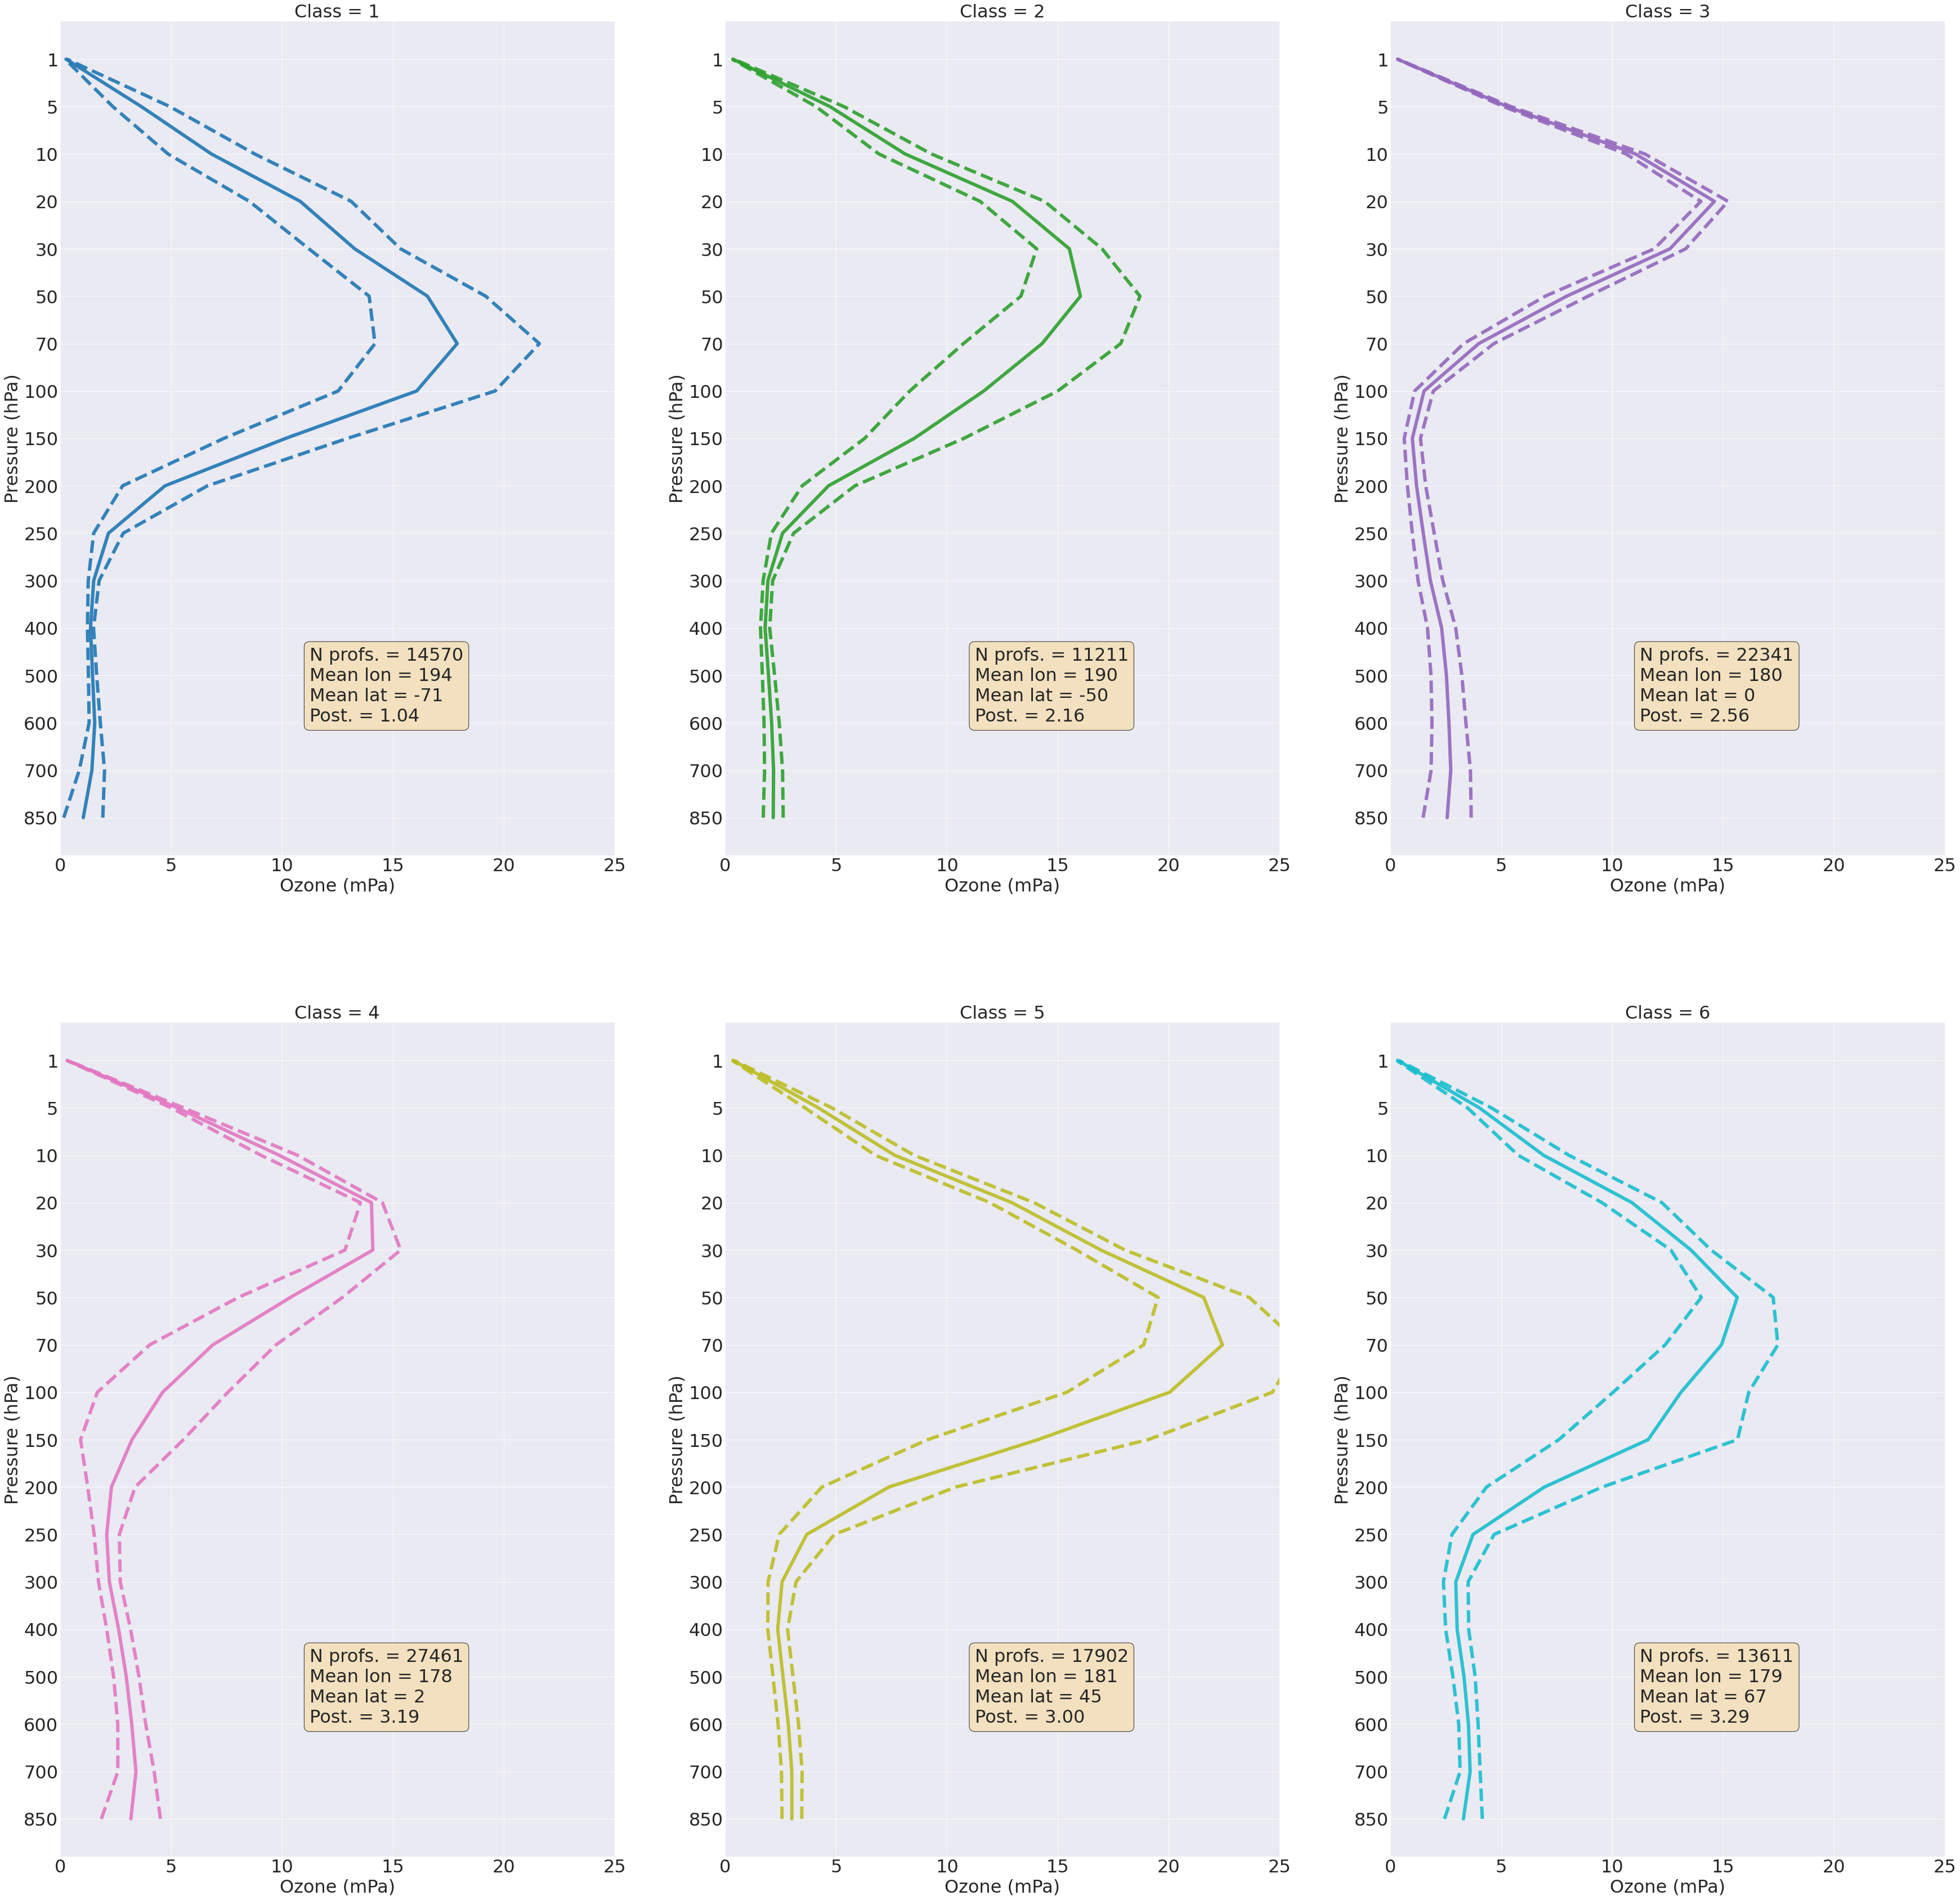

In [55]:
#classes for no carbon emission reduction (SSP585)
cNorm = colors.Normalize(vmin=0, vmax=n_comp)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))

# declare arrays
max_ozone_pressure_ssp585 = np.zeros(n_comp)
max_ozone_value_ssp585 = np.zeros(n_comp)
std_ozone_value_ssp585 = np.zeros(n_comp)
 
# iterate over groups
num = 0
for nrow in range(0,n_comp):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
     # extract means
    mean_lon3 = dfg_means3.iloc[nrow,0]
    mean_lat3 = dfg_means3.iloc[nrow,1]
    mean_maxpp3 = dfg_means3.iloc[nrow,4]
    mean_T3 = dfg_means3.iloc[nrow,4:].values
    
    # extract stdevs
    std_lon3 = dfg_stds3.iloc[nrow,0]
    std_lat3 = dfg_stds3.iloc[nrow,1]
    std_maxpp3 = dfg_stds3.iloc[nrow,4]
    std_T3 = dfg_stds3.iloc[nrow,4:].values
    
     # calculate it
    max_ozone_pressure_ssp585[nrow] = p[np.argmax(mean_T3)]
    max_ozone_value_ssp585[nrow] = np.max(mean_T3)
    std_ozone_value_ssp585[nrow] = np.max(std_T3)
    
    print('Class'+str(num))
    print('Maximum at ' + str(max_ozone_pressure_ssp585[nrow]) + ' hPa')
    print('Maximum ozone value of mean profile = ' + str(max_ozone_value_ssp585[nrow]))
    print('Standard deviation at level = ' + str(std_ozone_value_ssp585[nrow]))
    
    
    # select subplot
    plt.subplot(int(np.ceil(n_comp/5)),3,num)
    #plt.subplot(3,3,num)
    plt.plot(mean_T3, p1, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T3+std_T3, p1, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T3-std_T3, p1, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    #plt.ylim([0,950])
    ax = plt.gca()
    #ax.invert_yaxis() 
    plt.xlim([0, 25])
    #ax.grid(True)
    
   #text box
    fs = 32 # font size
    plt.xlabel('Ozone (mPa)', fontsize=fs)
    plt.ylabel('Pressure (hPa)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    mpl.rc('xtick', labelsize=fs)     
    mpl.rc('ytick', labelsize=fs)
    
    # this creates the test boxes that display the class statistics
    textstr = '\n'.join((
        r'N profs. = %i' % (nprofs3[nrow], ),
        r'Mean lon = %i' % (mean_lon3, ),
        r'Mean lat = %i' % (mean_lat3, ),
        r'Post. = %.2f' % (mean_maxpp3, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    # place a text box in upper left in axes coords
    ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs,
            verticalalignment='top', bbox=props)   
   
   #plt.show()
plt.savefig("figures/ssp585profiles.pdf",
           bbox_inches="tight",transparent=False)

In the inset text boxes above, "N profs." is the number of profiles in each class. Also shown are class mean values for longitude, latitude, and maximum posterior probability.

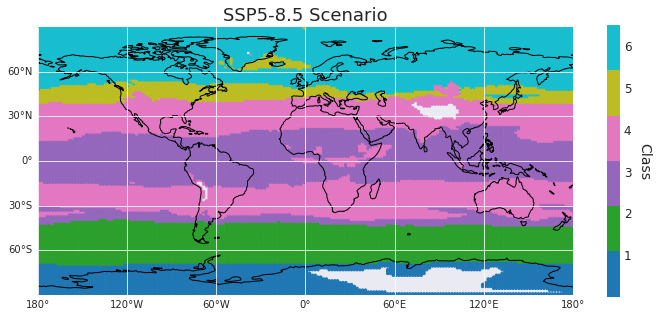

In [56]:
# median label 
df3plot = df3.groupby(['x','y']).median().reset_index()
#colormap with no carbon emission reduction (SSP585)
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
#ax.stock_img()
ax.coastlines()

cplot = df3plot['label_sorted'].values + 1

CS3 = plt.scatter(df3plot['x'].values, df3plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,s=6.0,
                 vmin=0.0, vmax=n_comp+0.5)
                 #transform=ccrs.Geodetic(),
                 

colorbar = plt.colorbar(CS3, shrink=0.5)
cblabels = np.arange(1, int(n_comp)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)
colorbar.ax.tick_params(labelsize='large')
plt.title('SSP5-8.5 Scenario', fontsize=18) 
#plt.show()

# eventually, uncomment this in order to save the images
if save_figs==True:
    plt.savefig("figures/ssp585_labels",bbox_inches="tight",transparent=False)
#plt.savefig("figures/ssp585_labels",bbox_inches="tight",transparent=False)

In [57]:
df3['cos_lat'] = np.cos(np.radians(df3['y']))
A3 = df3.groupby('label_sorted').sum()['cos_lat']

area_ssp585 = 100*A3/np.sum(A3)
area_ssp585

label_sorted
0     6.388463
1    10.107927
2    31.289868
3    34.007641
4    11.042201
5     7.163901
Name: cos_lat, dtype: float64

## Next section is to generate table in latex script directly from here

#### Ozone concentartion at selected pressure level (850 hPa)

In [58]:
#generate table
# historical
surface_means_hist = df1[['label_sorted','850']].groupby('label_sorted').mean()
surface_stds_hist  = df1[['label_sorted','850']].groupby('label_sorted').std()

# SSP126
surface_means_ssp126 = df2[['label_sorted','850']].groupby('label_sorted').mean()
surface_stds_ssp126  = df2[['label_sorted','850']].groupby('label_sorted').std()

# SSP585
surface_means_ssp585 = df3[['label_sorted','850']].groupby('label_sorted').mean()
surface_stds_ssp585  = df3[['label_sorted','850']].groupby('label_sorted').std()

# establish table 
header = ['Class','Hist (mean)','(std)','SSP126 (mean)','(std)','SSP585 (mean)','(std)']
A = pd.concat([pd.Series((1,2,3,4,5,6)),
               surface_means_hist,
               surface_stds_hist,
               surface_means_ssp126,
               surface_stds_ssp126,
               surface_means_ssp585,
               surface_stds_ssp585],axis=1).round(2)
rows = A.values.tolist()
rows.append(header)
surface_table = rows[-1:]+rows[:-1]
surface_table

# create table object
table = Texttable()
#table.set_cols_align(["c"] * 7)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(surface_table)

print('\nTexttable Table:')
print(table.draw())

print('\nTexttable Latex:')
print(latextable.draw_latex(table, caption="Ozone concentration statistics at 850 hPa for the historical, SSP126, and SSP585 experiments, shown in mPa"))


Texttable Table:
Class | Hist (mean) | (std) | SSP126 (mean) | (std) | SSP585 (mean) | (std)
======+=============+=======+===============+=======+===============+======
1     | 0.990       | 0.890 | 0.900         | 0.790 | 1.040         | 0.880
2     | 2.150       | 0.380 | 1.980         | 0.330 | 2.160         | 0.450
3     | 2.990       | 0.950 | 2.210         | 0.700 | 2.560         | 1.080
4     | 3.360       | 1.290 | 2.620         | 0.920 | 3.190         | 1.330
5     | 3.190       | 0.440 | 2.310         | 0.260 | 3             | 0.440
6     | 2.940       | 0.780 | 2.250         | 0.610 | 3.290         | 0.850

Texttable Latex:
\begin{table}
	\begin{center}
		\begin{tabular}{l|l|l|l|l|l|l}
			Class & Hist (mean) & (std) & SSP126 (mean) & (std) & SSP585 (mean) & (std) \\
			\hline
			1 & 0.990 & 0.890 & 0.900 & 0.790 & 1.040 & 0.880 \\
			2 & 2.150 & 0.380 & 1.980 & 0.330 & 2.160 & 0.450 \\
			3 & 2.990 & 0.950 & 2.210 & 0.700 & 2.560 & 1.080 \\
			4 & 3.360 & 1.290 & 2.620 & 0.

In [59]:
from tabulate import tabulate
from texttable import Texttable

import latextable

# create list of lists for table
header = ['Class', 'Historical', 'SSP126', 'SSP585']
all_areas = pd.concat([pd.Series((1,2,3,4,5,6)),area_hist, area_ssp126, area_ssp585], axis=1).round(1)
rows = all_areas.values.tolist()
rows.append(header)
area_table = rows[-1:]+rows[:-1]

# create table object
table = Texttable()
table.set_cols_align(["c"] * 4)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(area_table)

print('\nTexttable Table:')
print(table.draw())

print('\nTexttable Latex:')
print(latextable.draw_latex(table, caption="Relative area occupied by each class, shown in percentages."))


Texttable Table:
Class | Historical | SSP126 | SSP585
======+============+========+=======
  1   |   4.900    | 5.300  | 6.400 
  2   |   13.400   | 12.200 | 10.100
  3   |   33.300   | 27.700 | 31.300
  4   |   31.900   | 39.300 |   34  
  5   |   8.300    | 8.500  |   11  
  6   |   8.200    |   7    | 7.200 

Texttable Latex:
\begin{table}
	\begin{center}
		\begin{tabular}{c|c|c|c}
			Class & Historical & SSP126 & SSP585 \\
			\hline
			1 & 4.900 & 5.300 & 6.400 \\
			2 & 13.400 & 12.200 & 10.100 \\
			3 & 33.300 & 27.700 & 31.300 \\
			4 & 31.900 & 39.300 & 34 \\
			5 & 8.300 & 8.500 & 11 \\
			6 & 8.200 & 7 & 7.200 \\
		\end{tabular}
	\end{center}
	\caption{Relative area occupied by each class, shown in percentages.}
\end{table}


In [60]:
names = pd.Series(('Southern Hemispheric (Classes 1+2)',
                                        'Tropical (Classes 3+4)',
                                        'Northern Hemispheric (Classes 5+6)'))

m1 = pd.Series(all_areas.iloc[0:2,1:].sum().values.round(1).tolist())  # returns the row for 1+2 (southern hemisphere)
m2 = pd.Series(all_areas.iloc[2:4,1:].sum().values.round(1).tolist())  # returns the row for 3+4 (tropics)
m3 = pd.Series(all_areas.iloc[4:6,1:].sum().values.round(1).tolist())  # returns the row for 5+6 (northern hemisphere)
areas_by_region = pd.concat([m1,m2,m3], axis=1).round(1).T

header = ['Historical', 'SSP126', 'SSP585']
rows = areas_by_region.values.tolist()
rows.append(header)
area_region_table = rows[-1:]+rows[:-1]

In [61]:
area_region_table

[['Historical', 'SSP126', 'SSP585'],
 [18.3, 17.5, 16.5],
 [65.2, 67.0, 65.3],
 [16.5, 15.5, 18.2]]

In [62]:
# create table object
table = Texttable()
table.set_cols_align(["c"] * 3)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(area_region_table)

print('\nTexttable Table:')
print(table.draw())

print('\nTexttable Latex:')
print(latextable.draw_latex(table, caption="Relative area coverage of three combined regions, shown in percentages."))


Texttable Table:
Historical | SSP126 | SSP585
===========+========+=======
  18.300   | 17.500 | 16.500
  65.200   |   67   | 65.300
  16.500   | 15.500 | 18.200

Texttable Latex:
\begin{table}
	\begin{center}
		\begin{tabular}{c|c|c}
			Historical & SSP126 & SSP585 \\
			\hline
			18.300 & 17.500 & 16.500 \\
			65.200 & 67 & 65.300 \\
			16.500 & 15.500 & 18.200 \\
		\end{tabular}
	\end{center}
	\caption{Relative area coverage of three combined regions, shown in percentages.}
\end{table}
